# Multiplane imaging workflow
Notebook set up as described by babcock et al. [https://storm-analysis.readthedocs.io/en/stable/analysis.html](https://storm-analysis.readthedocs.io/en/stable/analysis.html). 
* starting point is cropped planes from raw camera frames set up in separate folders
* calibration file is created from accent calibration script by ries lab and converted into the appropriate format for this processing




In [32]:
# general imports 
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import pickle
from tkinter import filedialog
from tkinter import *
import json
from tqdm import tqdm
import csv
from natsort import natsorted

In [33]:
from xml.etree import ElementTree
import storm_analysis.sa_library.sa_h5py as saH5Py

def load_multiplane_calibration(filename):
    if not os.path.exists(filename):
        # ask for user input for calibraiton
        root = Tk()
        root.withdraw()
        filepath = filedialog.askopenfile(title='Select calibration data file', filetypes =[('Calibration file', '*.json')])
        fopen = filepath.name
    else:
        fopen = os.path.join(filename)
    f = open(fopen)
    cal = json.load(f, object_hook=jsonKeys2int) 
    return cal


def jsonKeys2int(x):
    if isinstance(x, dict):
        return {(int(k) if k.isnumeric() else k):v for k,v in x.items()}
    return x


def txt2csv(txtname):
    csvname = txtname.replace(".txt", ".csv")
    with open(txtname, 'r') as in_file:
        stripped = (line.strip() for line in in_file)
        lines = (line.split(",") for line in stripped if line)
        with open(csvname, 'w') as out_file:
            writer = csv.writer(out_file)
            writer.writerows(lines)

    print(f"Finished writing {csvname}")

def hdf5PxlToTxtNm(hdf5_name, txt_name, pixel_size):
    locfields = ['x', 'y', 'z']
    nmfields = [f + "nm" for f in locfields]
    scale_map = {'x': pixel_size, 'y': pixel_size, 'z': 1000.0}

    with saH5Py.SAH5Reader(hdf5_name) as h5:
        # nm_per_pixel = h5.getPixelSize()  
        _ = h5.getMovieInformation()

        def _fmt(val, is_int):
            return str(val) if is_int else f"{val:.3f}"

        with open(txt_name, "w") as fp:
            has_header = False
            fields = None

            # Convert tracks.
            if h5.hasTracks():
                index = 0
                print("Converting tracks.")
                for tracks in tqdm(h5.tracksIterator()):
                    if not has_header:
                        fields = sorted(tracks.keys())
                        fp.write(",".join(["index"] + fields + nmfields) + "\n")
                        has_header = True

                    for i in range(tracks["x"].size):
                        row = [str(index)]
                        # original fields
                        for field in fields:
                            is_int = (tracks[field].dtype == np.int32)
                            row.append(_fmt(tracks[field][i], is_int))
                        # nm fields in x,y,z order with requested scaling
                        for f in locfields:
                            is_int = (tracks[f].dtype == np.int32)
                            row.append(_fmt(tracks[f][i] * scale_map[f], is_int=False))
                        fp.write(",".join(row) + "\n")
                        index += 1

            # Convert localizations.
            else:
                index = 0
                print("Converting localizations.")
                for fnum, locs in tqdm(h5.localizationsIterator(drift_corrected=False)):
                    if not has_header:
                        fields = sorted(locs.keys())
                        fp.write(",".join(["index", "frame"] + fields + nmfields) + "\n")
                        has_header = True

                    for i in range(locs["x"].size):
                        row = [str(index), str(fnum)]
                        # original fields
                        for field in fields:
                            is_int = (locs[field].dtype == np.int32)
                            row.append(_fmt(locs[field][i], is_int))
                        # nm fields in x,y,z order with requested scaling
                        for f in locfields:
                            is_int = (locs[f].dtype == np.int32)
                            row.append(_fmt(locs[f][i] * scale_map[f], is_int=False))
                        fp.write(",".join(row) + "\n")
                        index += 1

Load and display parameter and calibration files 

In [34]:
root = r'D:\moritz\Technical_paper\202508_smlm_test\CS4_e642nm_kinetix2_dz25_3\cal_data' # r'D:\moritz\Technical_paper\4x2\smlm_tilt_corrected_200nmbeads_test_v2\babcock_data_v2' #
os.chdir(root)
print(os.getcwd())

script_root = r'E:\GitHub\storm-analysis\storm_analysis'

filepath_mcal = os.path.join(root, 'cal.json')
mcal = load_multiplane_calibration(filepath_mcal)

#filepath_scmos_cal1 = os.path.join(root, 'cal.json')
#filepath_scmos_cal2 = 
analysis_params = 'single_plane_daofit.xml'
zcal_fit_params = 'zcal.xml'
#filepath_analysis_params = os.path.join(root, analysis_params)

# processing parameters
global ref_plane, exp_time, pixel_size, camera_gain, camera_offset, iterations, dz, focus_plane, threshold
ref_plane = 0 # python indexing
exp_time = 10
pixel_size = 108
camera_gain = 5
camera_offset = 100
iterations = 1000
model = '2dfixed'
dz = int(mcal['dz_stage'])
threshold = 70
focus_plane = int(mcal['psf_slices']/2)
spline_z_range = int(0.4*mcal['steps'])*int(mcal['dz_stage'])/1000

D:\moritz\Technical_paper\202508_smlm_test\CS4_e642nm_kinetix2_dz25_3\cal_data


In [35]:
import storm_analysis.sa_library.parameters as parameters
def createParametersFile(max_frame, start_frame, filename, roi_size=15):
    """
    Create a 3D-DAOSTORM parameters file.
    """
    params = parameters.ParametersDAO()

    params.setAttr("max_frame", "int", max_frame)    
    params.setAttr("start_frame", "int", start_frame)
    
    params.setAttr("background_sigma", "float", 8.0)
    params.setAttr("camera_gain", "float", camera_gain)
    params.setAttr("camera_offset", "float", camera_offset)
    params.setAttr("find_max_radius", "int", 5)
    params.setAttr("foreground_sigma", "float", 3.0)
    params.setAttr("iterations", "int", iterations)
    params.setAttr("model", "string", model)
    params.setAttr("pixel_size", "float", pixel_size)
    params.setAttr("roi_size", "int", roi_size)
    params.setAttr("sigma", "float", 3)
    params.setAttr("threshold", "float", threshold)

    params.setAttr("no_fitting", "int", 0)

    # Z fitting.
    params.setAttr("do_zfit", "int", 0)

    params.setAttr("cutoff", "float", 0.0)    
    params.setAttr("max_z", "float", 0.5)
    params.setAttr("min_z", "float", -0.5)
    params.setAttr("z_value", "float", 0.0)
    params.setAttr("z_step", "float", 0.001)

    params.setAttr("wx_wo", "float", 300.0)
    params.setAttr("wx_c", "float", 150.0)
    params.setAttr("wx_d", "float", 400.0)
    params.setAttr("wxA", "float", 0.0)
    params.setAttr("wxB", "float", 0.0)
    params.setAttr("wxC", "float", 0.0)
    params.setAttr("wxD", "float", 0.0)

    params.setAttr("wy_wo", "float", 300.0)
    params.setAttr("wy_c", "float", -150.0)
    params.setAttr("wy_d", "float", 400.0)
    params.setAttr("wyA", "float", 0.0)
    params.setAttr("wyB", "float", 0.0)
    params.setAttr("wyC", "float", 0.0)
    params.setAttr("wyD", "float", 0.0)

    # Do tracking.
    params.setAttr("descriptor", "string", "1")
    params.setAttr("radius", "float", "0.5")

    # Do drift-correction.
    params.setAttr("d_scale", "int", 2)
    params.setAttr("drift_correction", "int", 0)
    params.setAttr("frame_step", "int", 500)
    params.setAttr("z_correction", "int", 0)
    
    params.toXMLFile(filename)


createParametersFile(max_frame=focus_plane+1, start_frame=focus_plane, filename=analysis_params, roi_size=25)

createParametersFile(max_frame=-1, start_frame=-1, filename=zcal_fit_params, roi_size=25)

In [5]:
# create analysis files for each plane with respective focal plane
for i, fp in enumerate(mcal['fp']):
    param_fname = analysis_params.replace('.', f'_{i}.' )
    createParametersFile(max_frame=fp+1, start_frame=fp, filename=param_fname, roi_size=17)

### daostorm fitting of bead stack focal planes for marker ID in .hd5f


version 2023.02.26

Peak finding
Frame: 59 11 11

Added 11
   5 peak finding iterations.

   0 fits reset due to Cholesky failure.
   0 fits reset due to image margin.
   1 fits reset due to negative value in fit function.
   0 fits reset due to negative height.
   4 fits reset due to non-decreasing error (LM).
   0 fits did not converge.
   0 fits were lost.
   0 peaks lost to proximity filter.
   0 peaks lost to low significance.
   96 fitting iterations.

Tracking.
 processing frame 0, 0 tracks
Added 11 tracks

Checking z values.
 track group 0

Analysis complete
Written focal plane locs of z-plane 0


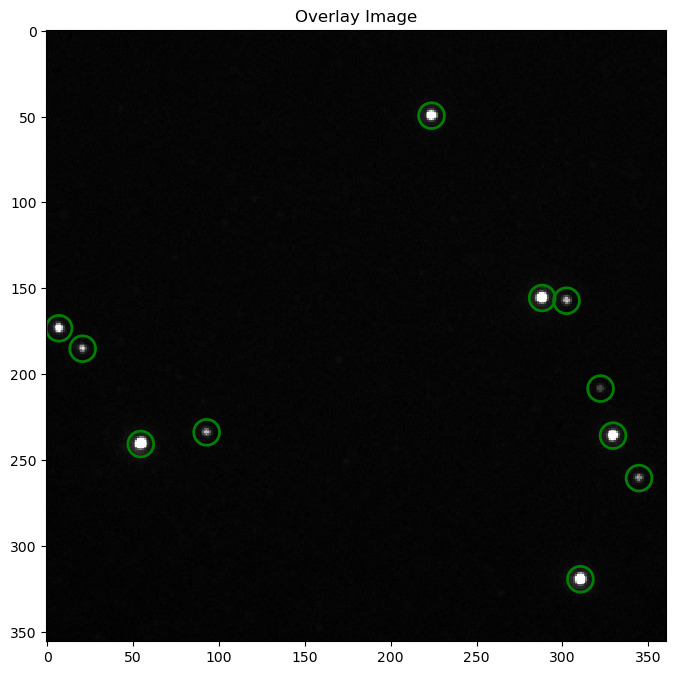


version 2023.02.26

Peak finding
Frame: 74 11 11

Added 11
   5 peak finding iterations.

   0 fits reset due to Cholesky failure.
   0 fits reset due to image margin.
   6 fits reset due to negative value in fit function.
   0 fits reset due to negative height.
   2 fits reset due to non-decreasing error (LM).
   0 fits did not converge.
   0 fits were lost.
   0 peaks lost to proximity filter.
   0 peaks lost to low significance.
   121 fitting iterations.

Tracking.
 processing frame 0, 0 tracks
Added 11 tracks

Checking z values.
 track group 0

Analysis complete
Written focal plane locs of z-plane 1


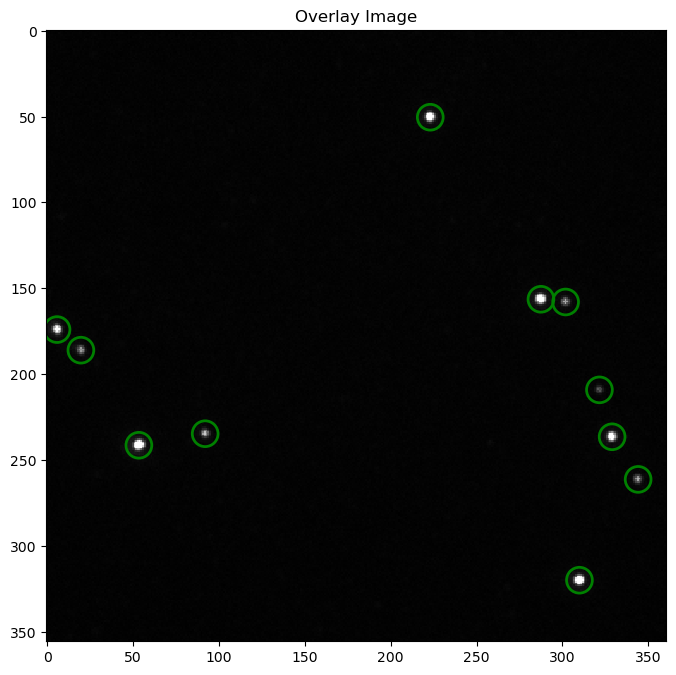


version 2023.02.26

Peak finding
Frame: 89 11 11

Added 11
   5 peak finding iterations.

   0 fits reset due to Cholesky failure.
   0 fits reset due to image margin.
   2 fits reset due to negative value in fit function.
   0 fits reset due to negative height.
   6 fits reset due to non-decreasing error (LM).
   0 fits did not converge.
   0 fits were lost.
   0 peaks lost to proximity filter.
   0 peaks lost to low significance.
   102 fitting iterations.

Tracking.
 processing frame 0, 0 tracks
Added 11 tracks

Checking z values.
 track group 0

Analysis complete
Written focal plane locs of z-plane 2


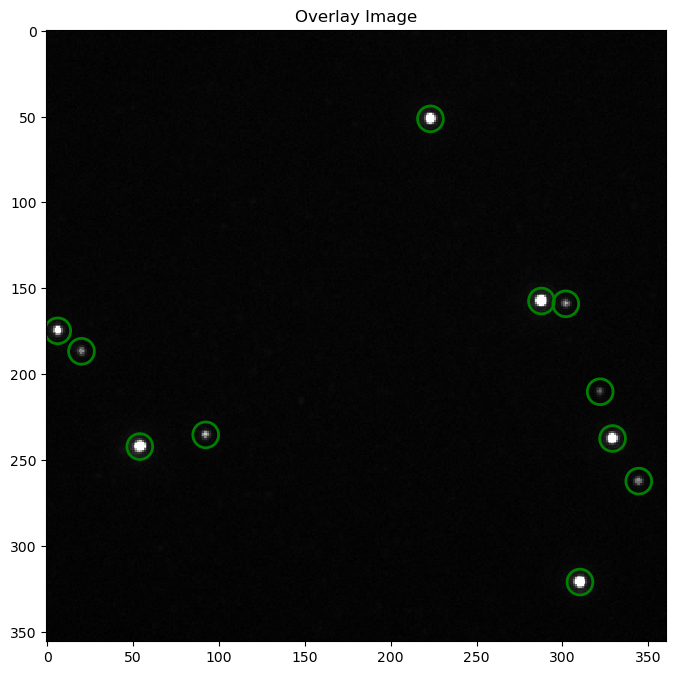


version 2023.02.26

Peak finding
Frame: 104 11 11

Added 11
   5 peak finding iterations.

   0 fits reset due to Cholesky failure.
   0 fits reset due to image margin.
   2 fits reset due to negative value in fit function.
   0 fits reset due to negative height.
   6 fits reset due to non-decreasing error (LM).
   0 fits did not converge.
   0 fits were lost.
   0 peaks lost to proximity filter.
   0 peaks lost to low significance.
   103 fitting iterations.

Tracking.
 processing frame 0, 0 tracks
Added 11 tracks

Checking z values.
 track group 0

Analysis complete
Written focal plane locs of z-plane 3


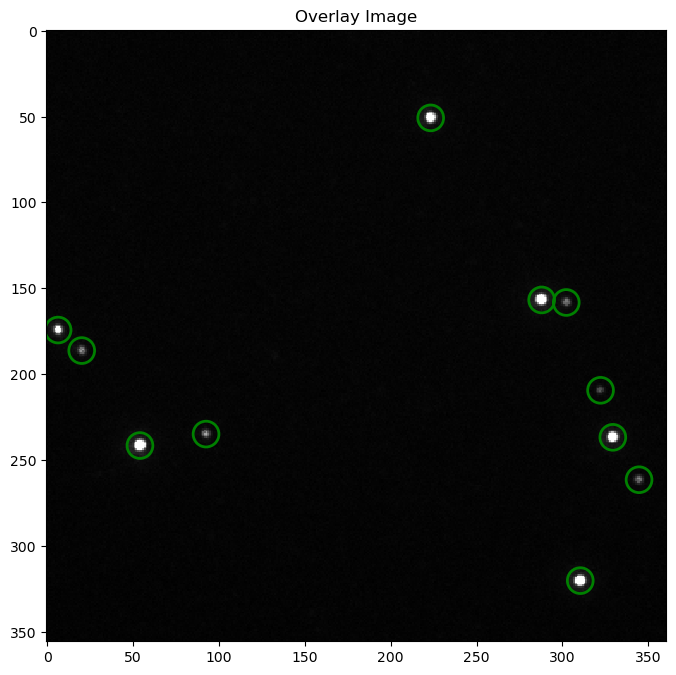


version 2023.02.26

Peak finding
Frame: 112 10 10

Added 10
   5 peak finding iterations.

   0 fits reset due to Cholesky failure.
   0 fits reset due to image margin.
   0 fits reset due to negative value in fit function.
   0 fits reset due to negative height.
   0 fits reset due to non-decreasing error (LM).
   0 fits did not converge.
   0 fits were lost.
   0 peaks lost to proximity filter.
   0 peaks lost to low significance.
   89 fitting iterations.

Tracking.
 processing frame 0, 0 tracks
Added 10 tracks

Checking z values.
 track group 0

Analysis complete
Written focal plane locs of z-plane 4


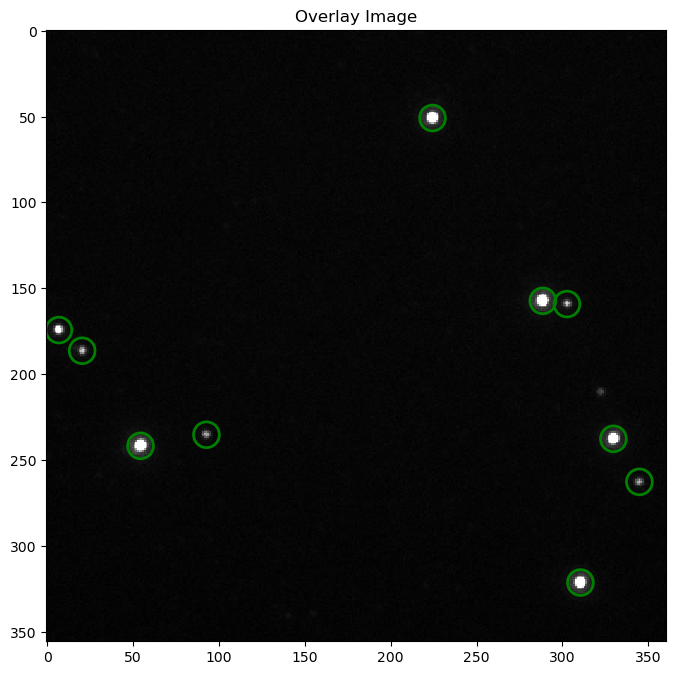


version 2023.02.26

Peak finding
Frame: 131 11 11

Added 11
   5 peak finding iterations.

   0 fits reset due to Cholesky failure.
   0 fits reset due to image margin.
   4 fits reset due to negative value in fit function.
   0 fits reset due to negative height.
   3 fits reset due to non-decreasing error (LM).
   0 fits did not converge.
   0 fits were lost.
   0 peaks lost to proximity filter.
   0 peaks lost to low significance.
   111 fitting iterations.

Tracking.
 processing frame 0, 0 tracks
Added 11 tracks

Checking z values.
 track group 0

Analysis complete
Written focal plane locs of z-plane 5


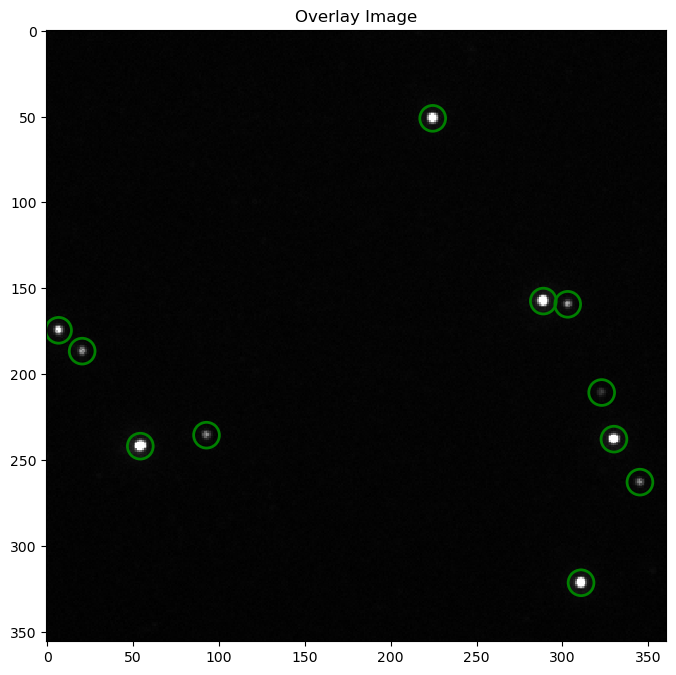


version 2023.02.26

Peak finding
Frame: 146 11 11

Added 11
   5 peak finding iterations.

   0 fits reset due to Cholesky failure.
   0 fits reset due to image margin.
   3 fits reset due to negative value in fit function.
   0 fits reset due to negative height.
   1 fits reset due to non-decreasing error (LM).
   0 fits did not converge.
   0 fits were lost.
   0 peaks lost to proximity filter.
   0 peaks lost to low significance.
   112 fitting iterations.

Tracking.
 processing frame 0, 0 tracks
Added 11 tracks

Checking z values.
 track group 0

Analysis complete
Written focal plane locs of z-plane 6


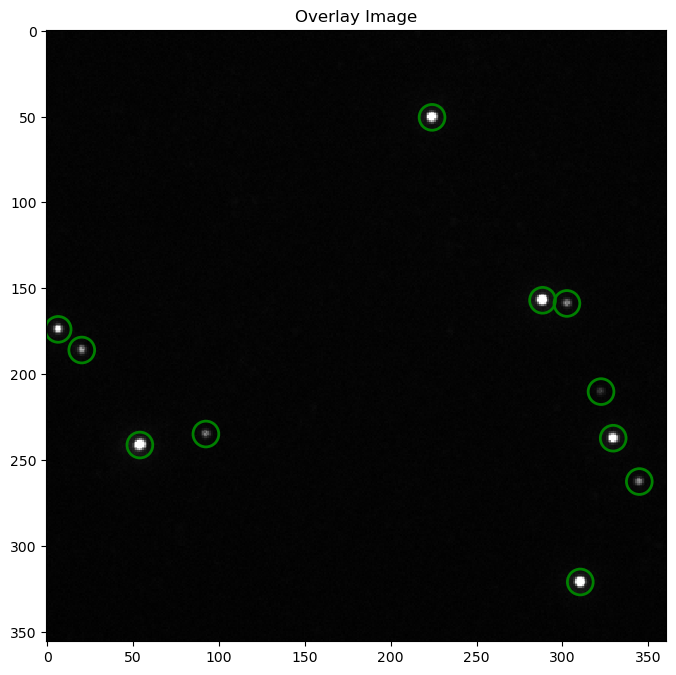


version 2023.02.26

Peak finding
Frame: 160 11 11

Added 11
   5 peak finding iterations.

   0 fits reset due to Cholesky failure.
   0 fits reset due to image margin.
   2 fits reset due to negative value in fit function.
   0 fits reset due to negative height.
   3 fits reset due to non-decreasing error (LM).
   0 fits did not converge.
   0 fits were lost.
   0 peaks lost to proximity filter.
   0 peaks lost to low significance.
   102 fitting iterations.

Tracking.
 processing frame 0, 0 tracks
Added 11 tracks

Checking z values.
 track group 0

Analysis complete
Written focal plane locs of z-plane 7


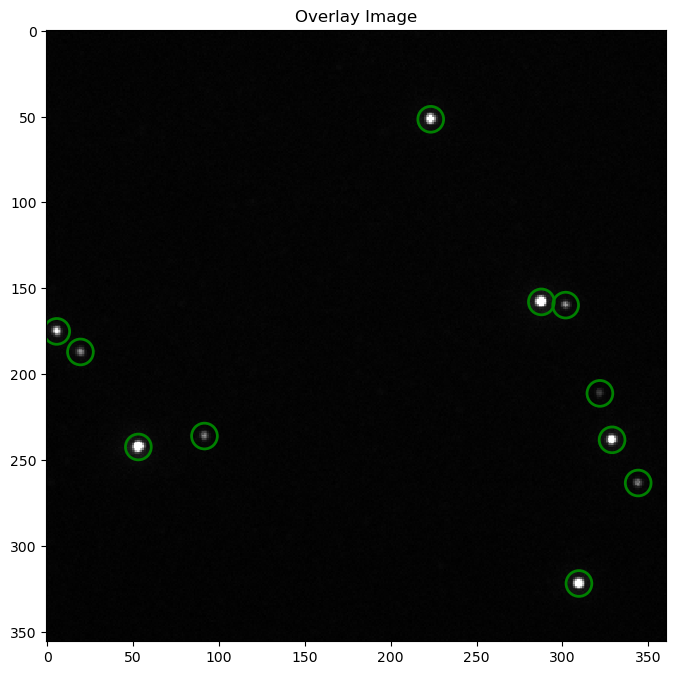

In [6]:
from storm_analysis.daostorm_3d.mufit_analysis import analyze
#from storm_analysis.sa_utilities. hdf5_to_image import render2DImage
import storm_analysis.jupyter_examples.overlay_image as overlay_image

base_pattern = r'beads_zcal_ch(\d+)\.tif'
#base_pattern = r'corrected_beads_zcal_ch(\d+)\.tif'
focal_planes_list = [f for f in os.listdir(root) if re.match(base_pattern, f)]
for i, f in enumerate(focal_planes_list):
    id_group = re.match(base_pattern, f)
    outname = f'locs_plane_{int(id_group.group(1))}.hdf5'

    # development
    if os.path.isfile(os.path.join(root, outname)):
        os.remove(os.path.join(root, outname))

    param_fname = analysis_params.replace('.', f'_{i}.' )
    analyze(f, outname, param_fname)
    print(f"Written focal plane locs of z-plane {id_group.group(1)}")
    #plt.imshow(render2DImage(outname))
    #plt.show()
    overlay_image.overlayImage(f, outname, mcal['fp'][i])
    


### micrometry mapping of .hd5f locs from focal planes for transforms

In [7]:
from storm_analysis.micrometry.micrometry import runMicrometry
marker_pattern = r'locs_plane_(\d+)\.hdf5'
plane_locs_list = [f for f in os.listdir(root) if re.match(marker_pattern, f)]

plane_locs_list

['locs_plane_0.hdf5',
 'locs_plane_1.hdf5',
 'locs_plane_2.hdf5',
 'locs_plane_3.hdf5',
 'locs_plane_4.hdf5',
 'locs_plane_5.hdf5',
 'locs_plane_6.hdf5',
 'locs_plane_7.hdf5']

Using ref: locs_plane_0.hdf5, target locs_plane_1.hdf5 
Making quads for the 'reference' data.
Created 98 quads

Making quads for the 'other' data.
Created 98 quads

Comparing quads.


d:\.anaconda\envs\mp_smlm\Lib\site-packages\storm_analysis-2.2-py3.12.egg\storm_analysis\micrometry\quads.py:181: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return [numpy.linalg.lstsq(m, x)[0],
d:\.anaconda\envs\mp_smlm\Lib\site-packages\storm_analysis-2.2-py3.12.egg\storm_analysis\micrometry\quads.py:182: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  numpy.linalg.lstsq(m, y)[0]]


Match 0 0.72 7.78e-06 11.43
Match 1 0.65 7.78e-06 11.34
Match 2 0.64 7.78e-06 11.32
Match 3 0.90 7.78e-06 11.65
Match 4 0.92 7.78e-06 11.68
Match 5 1.00 7.78e-06 11.76
Match 6 0.99 7.78e-06 11.76
Match 7 0.99 7.78e-06 11.76
Match 8 0.44 7.78e-06 10.95
Match 9 0.99 7.78e-06 11.75
Match 10 1.00 7.78e-06 11.76
Match 11 0.99 7.78e-06 11.76
Match 12 1.00 7.78e-06 11.76
Match 13 0.98 7.78e-06 11.74
Match 14 0.99 7.78e-06 11.76
Match 15 0.99 7.78e-06 11.76
Match 16 1.00 7.78e-06 11.76
Match 17 1.00 7.78e-06 11.76
Match 18 0.69 7.78e-06 11.40
Match 19 0.97 7.78e-06 11.73
Match 20 0.98 7.78e-06 11.75
Match 21 0.99 7.78e-06 11.76
Match 22 0.99 7.78e-06 11.75
Match 23 0.98 7.78e-06 11.74
Match 24 0.71 7.78e-06 11.43
Match 25 1.00 7.78e-06 11.76
Match 26 0.99 7.78e-06 11.75
Match 27 1.00 7.78e-06 11.76
Match 28 0.99 7.78e-06 11.76
Match 29 1.00 7.78e-06 11.76
Match 30 0.98 7.78e-06 11.75
Match 31 0.60 7.78e-06 11.26
Match 32 0.98 7.78e-06 11.75
Match 33 0.99 7.78e-06 11.75
Match 34 0.98 7.78e-06 1

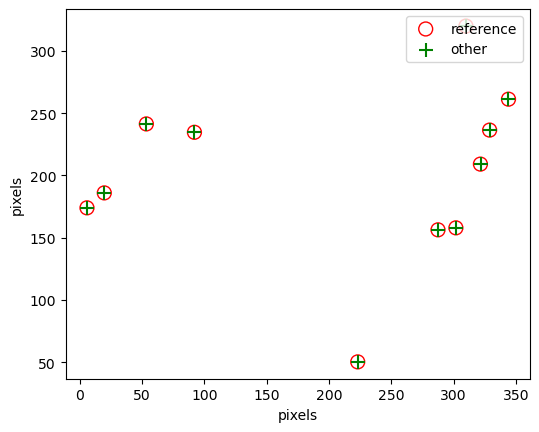

Written mapping: c0_c1.map
Using ref: locs_plane_0.hdf5, target locs_plane_2.hdf5 
Making quads for the 'reference' data.
Created 98 quads

Making quads for the 'other' data.
Created 98 quads

Comparing quads.
Match 0 0.73 7.78e-06 11.45
Match 1 0.81 7.78e-06 11.55
Match 2 0.78 7.78e-06 11.52
Match 3 0.80 7.78e-06 11.55
Match 4 0.95 7.78e-06 11.72
Match 5 1.00 7.78e-06 11.76
Match 6 1.00 7.78e-06 11.76
Match 7 1.00 7.78e-06 11.76
Match 8 0.96 7.78e-06 11.73
Match 9 1.00 7.78e-06 11.76
Match 10 1.00 7.78e-06 11.76
Match 11 1.00 7.78e-06 11.76
Match 12 1.00 7.78e-06 11.76
Match 13 1.00 7.78e-06 11.76
Match 14 1.00 7.78e-06 11.76
Match 15 1.00 7.78e-06 11.76
Match 16 1.00 7.78e-06 11.76
Match 17 1.00 7.78e-06 11.76
Match 18 0.96 7.78e-06 11.72
Match 19 1.00 7.78e-06 11.76
Match 20 1.00 7.78e-06 11.76
Match 21 1.00 7.78e-06 11.76
Match 22 1.00 7.78e-06 11.76
Match 23 1.00 7.78e-06 11.76
Match 24 0.99 7.78e-06 11.75
Match 25 1.00 7.78e-06 11.76
Match 26 1.00 7.78e-06 11.76
Match 27 1.00 7.7

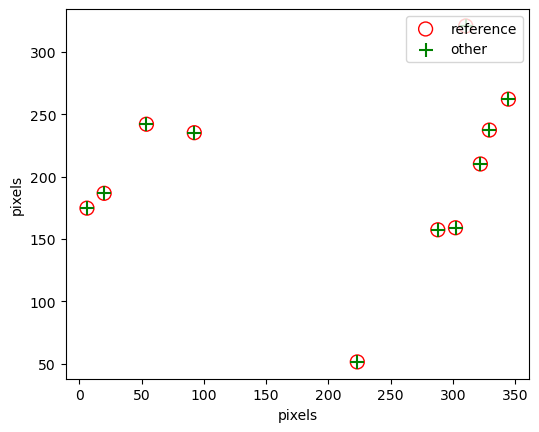

Written mapping: c0_c2.map
Using ref: locs_plane_0.hdf5, target locs_plane_3.hdf5 
Making quads for the 'reference' data.
Created 98 quads

Making quads for the 'other' data.
Created 98 quads

Comparing quads.
Match 0 0.62 7.78e-06 11.28
Match 1 0.62 7.78e-06 11.29
Match 2 0.62 7.78e-06 11.29
Match 3 0.71 7.78e-06 11.43
Match 4 0.96 7.78e-06 11.73
Match 5 0.99 7.78e-06 11.76
Match 6 0.99 7.78e-06 11.76
Match 7 1.00 7.78e-06 11.76
Match 8 0.67 7.78e-06 11.36
Match 9 0.99 7.78e-06 11.76
Match 10 1.00 7.78e-06 11.76
Match 11 0.99 7.78e-06 11.76
Match 12 0.99 7.78e-06 11.76
Match 13 0.99 7.78e-06 11.76
Match 14 1.00 7.78e-06 11.76
Match 15 1.00 7.78e-06 11.76
Match 16 0.99 7.78e-06 11.76
Match 17 0.99 7.78e-06 11.76
Match 18 0.84 7.78e-06 11.59
Match 19 0.99 7.78e-06 11.75
Match 20 0.99 7.78e-06 11.76
Match 21 0.99 7.78e-06 11.76
Match 22 0.99 7.78e-06 11.76
Match 23 0.99 7.78e-06 11.76
Match 24 0.95 7.78e-06 11.72
Match 25 0.99 7.78e-06 11.76
Match 26 1.00 7.78e-06 11.76
Match 27 1.00 7.7

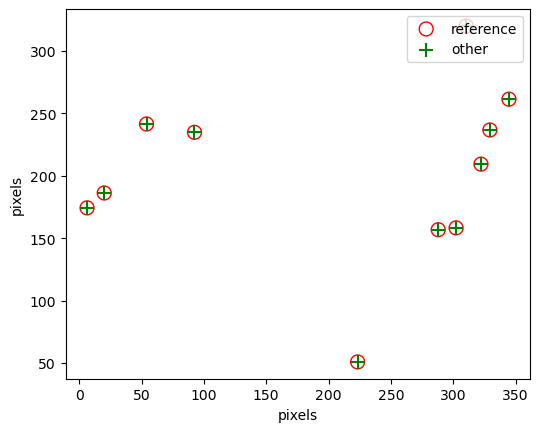

Written mapping: c0_c3.map
Using ref: locs_plane_0.hdf5, target locs_plane_4.hdf5 
Making quads for the 'reference' data.
Created 61 quads

Making quads for the 'other' data.
Created 98 quads

Comparing quads.
Match 0 0.48 7.78e-06 11.04
Match 1 0.88 7.78e-06 11.64
Match 2 0.90 7.78e-06 11.66
Match 3 0.89 7.78e-06 11.65
Match 4 0.90 7.78e-06 11.65
Match 5 0.37 7.78e-06 10.76
Match 6 0.88 7.78e-06 11.63
Match 7 0.88 7.78e-06 11.63
Match 8 0.88 7.78e-06 11.64
Match 9 0.89 7.78e-06 11.65
Match 10 0.90 7.78e-06 11.65
Match 11 0.89 7.78e-06 11.65
Match 12 0.88 7.78e-06 11.63
Match 13 0.89 7.78e-06 11.65
Match 14 0.85 7.78e-06 11.60
Match 15 0.58 7.78e-06 11.22
Match 16 0.89 7.78e-06 11.65
Match 17 0.90 7.78e-06 11.65
Match 18 0.86 7.78e-06 11.62
Match 19 0.90 7.78e-06 11.65
Match 20 0.89 7.78e-06 11.65
Match 21 0.46 7.78e-06 10.99
Match 22 0.87 7.78e-06 11.63
Match 23 0.89 7.78e-06 11.65
Match 24 0.89 7.78e-06 11.64
Match 25 0.85 7.78e-06 11.60
Match 26 0.85 7.78e-06 11.61
Match 27 0.83 7.7

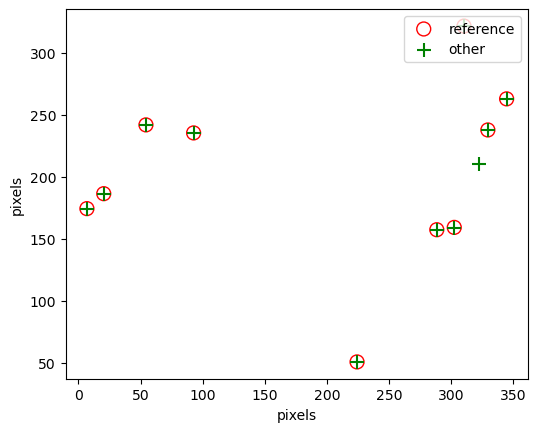

Written mapping: c0_c4.map
Using ref: locs_plane_0.hdf5, target locs_plane_5.hdf5 
Making quads for the 'reference' data.
Created 98 quads

Making quads for the 'other' data.
Created 98 quads

Comparing quads.
Match 0 0.58 7.78e-06 11.21
Match 1 0.59 7.78e-06 11.24
Match 2 0.58 7.78e-06 11.23
Match 3 0.61 7.78e-06 11.27
Match 4 0.84 7.78e-06 11.59
Match 5 0.99 7.78e-06 11.75
Match 6 0.97 7.78e-06 11.74
Match 7 0.98 7.78e-06 11.75
Match 8 0.37 7.78e-06 10.77
Match 9 0.98 7.78e-06 11.74
Match 10 0.98 7.78e-06 11.75
Match 11 0.98 7.78e-06 11.74
Match 12 0.99 7.78e-06 11.75
Match 13 0.97 7.78e-06 11.73
Match 14 0.99 7.78e-06 11.75
Match 15 0.97 7.78e-06 11.73
Match 16 0.99 7.78e-06 11.75
Match 17 0.97 7.78e-06 11.73
Match 18 0.49 7.78e-06 11.05
Match 19 0.97 7.78e-06 11.73
Match 20 0.97 7.78e-06 11.73
Match 21 0.95 7.78e-06 11.71
Match 22 0.98 7.78e-06 11.75
Match 23 0.97 7.78e-06 11.73
Match 24 0.58 7.78e-06 11.22
Match 25 0.97 7.78e-06 11.73
Match 26 0.98 7.78e-06 11.75
Match 27 0.98 7.7

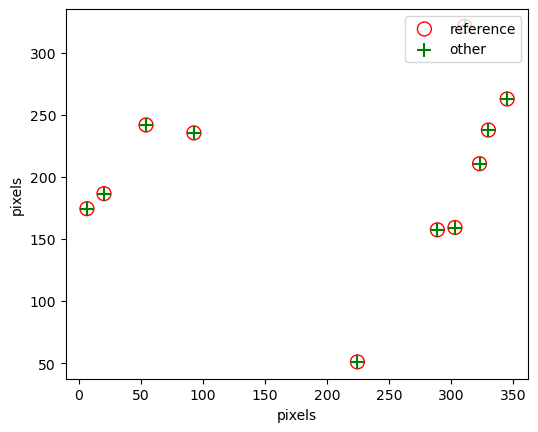

Written mapping: c0_c5.map
Using ref: locs_plane_0.hdf5, target locs_plane_6.hdf5 
Making quads for the 'reference' data.
Created 98 quads

Making quads for the 'other' data.
Created 98 quads

Comparing quads.
Match 0 0.58 7.78e-06 11.21
Match 1 0.61 7.78e-06 11.27
Match 2 0.58 7.78e-06 11.22
Match 3 0.63 7.78e-06 11.30
Match 4 0.95 7.78e-06 11.71
Match 5 0.98 7.78e-06 11.75
Match 6 0.97 7.78e-06 11.73
Match 7 0.98 7.78e-06 11.75
Match 8 0.38 7.78e-06 10.79
Match 9 0.98 7.78e-06 11.75
Match 10 0.98 7.78e-06 11.74
Match 11 0.98 7.78e-06 11.74
Match 12 0.99 7.78e-06 11.75
Match 13 0.99 7.78e-06 11.75
Match 14 0.98 7.78e-06 11.75
Match 15 0.98 7.78e-06 11.74
Match 16 0.99 7.78e-06 11.75
Match 17 0.96 7.78e-06 11.72
Match 18 0.58 7.78e-06 11.22
Match 19 0.98 7.78e-06 11.75
Match 20 0.98 7.78e-06 11.75
Match 21 0.92 7.78e-06 11.68
Match 22 0.97 7.78e-06 11.74
Match 23 0.98 7.78e-06 11.75
Match 24 0.77 7.78e-06 11.51
Match 25 0.94 7.78e-06 11.70
Match 26 0.98 7.78e-06 11.74
Match 27 0.95 7.7

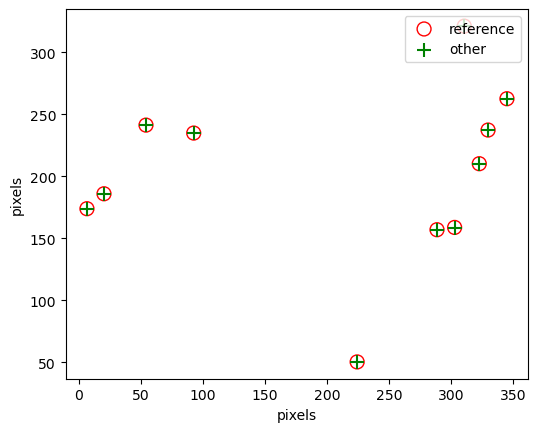

Written mapping: c0_c6.map
Using ref: locs_plane_0.hdf5, target locs_plane_7.hdf5 
Making quads for the 'reference' data.
Created 98 quads

Making quads for the 'other' data.
Created 98 quads

Comparing quads.
Match 0 0.57 7.78e-06 11.19
Match 1 0.59 7.78e-06 11.23
Match 2 0.57 7.78e-06 11.21
Match 3 0.60 7.78e-06 11.26
Match 4 0.97 7.78e-06 11.73
Match 5 0.98 7.78e-06 11.75
Match 6 0.96 7.78e-06 11.72
Match 7 0.98 7.78e-06 11.74
Match 8 0.37 7.78e-06 10.77
Match 9 0.97 7.78e-06 11.74
Match 10 0.98 7.78e-06 11.75
Match 11 0.97 7.78e-06 11.73
Match 12 0.98 7.78e-06 11.75
Match 13 0.98 7.78e-06 11.74
Match 14 0.98 7.78e-06 11.75
Match 15 0.97 7.78e-06 11.73
Match 16 0.98 7.78e-06 11.75
Match 17 0.97 7.78e-06 11.73
Match 18 0.47 7.78e-06 11.02
Match 19 0.97 7.78e-06 11.74
Match 20 0.97 7.78e-06 11.74
Match 21 0.92 7.78e-06 11.68
Match 22 0.98 7.78e-06 11.74
Match 23 0.97 7.78e-06 11.74
Match 24 0.90 7.78e-06 11.66
Match 25 0.94 7.78e-06 11.71
Match 26 0.98 7.78e-06 11.74
Match 27 0.95 7.7

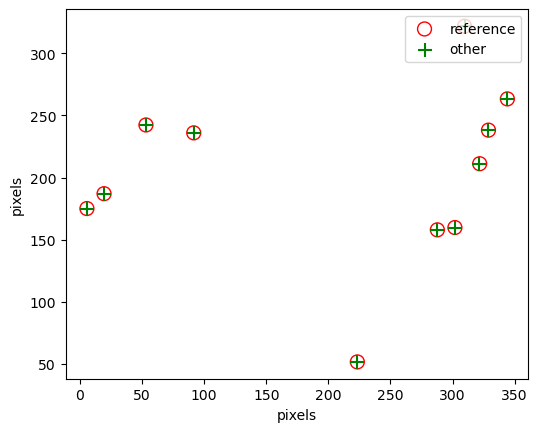

Written mapping: c0_c7.map


In [8]:
maps_list = []
for idx, f in enumerate(plane_locs_list):
    if idx == ref_plane: 
        continue 
    id_group = re.match(marker_pattern, f)
    outname = f'c{ref_plane}_c{int(id_group.group(1))}.map'
    maps_list.append(outname)

    print(f'Using ref: {plane_locs_list[ref_plane]}, target {f} ')
    runMicrometry(f, plane_locs_list[ref_plane], outname, max_size=300)
    print(f"Written mapping: {outname}")

### Merge mappings

In [9]:
# print mappings
print(f"Maps list: {maps_list}")
for f in maps_list:
    with open(f, "rb") as fp:
        a_map = pickle.load(fp)

    print(f)
    for elt in sorted(a_map):
        print(elt, a_map[elt])
    print()

Maps list: ['c0_c1.map', 'c0_c2.map', 'c0_c3.map', 'c0_c4.map', 'c0_c5.map', 'c0_c6.map', 'c0_c7.map']
c0_c1.map
0_1_x [ 1.13325046e+00  9.98409764e-01 -2.05833456e-04]
0_1_y [-9.36502563e-01  1.38623076e-04  1.00074397e+00]
1_0_x [-1.13453154e+00  1.00159194e+00  2.04640455e-04]
1_0_y [ 9.36188839e-01 -1.39282260e-04  9.99255622e-01]

c0_c2.map
0_1_x [ 0.90805641  0.9988669  -0.00109468]
0_1_y [-1.69595246e+00 -9.68579864e-04  1.00110394e+00]
1_0_x [-0.90714873  1.00113521  0.00109463]
1_0_y [1.69321543e+00 9.68578553e-04 9.98898324e-01]

c0_c3.map
0_1_x [ 0.84607959  0.99864334 -0.00139689]
0_1_y [-1.43367128e+00  1.63658525e-04  1.00189291e+00]
1_0_x [-0.84527788  1.00135824  0.00139656]
1_0_y [ 1.43115303e+00 -1.63537888e-04  9.98110001e-01]

c0_c4.map
0_1_x [-0.31412023  0.99849792  0.00239652]
0_1_y [-0.79852384 -0.00248879  0.99857362]
1_0_x [ 0.31268896  1.00149835 -0.00240362]
1_0_y [0.80109657 0.00249639 1.0014194 ]

c0_c5.map
0_1_x [-0.11095254  0.99689047  0.0023133 ]
0_1_y

In [36]:
from storm_analysis.micrometry.merge_maps import mergeMaps 

merged_map = mergeMaps(maps_list)
#same_maps_list = [f'c1_c1.map']*7
#merged_map = mergeMaps(same_maps_list)

map_name = 'merged_map.map'
with open(map_name, 'wb') as fp:
        pickle.dump(merged_map, fp)

### Measuring the PSF
1) Select good beads from focal plane in a single stack from the ref plane > beads_zcal_ch1.hdf5
2) Select good localizations to use for PSF determination for each channel.
python path/to/psf_localizations.py --bin beads_zcal_ch1.hdf5 --map map.map --aoi_size 12
3) Create averaged z stacks for each channel.

In [37]:
# Run loc fitter on whole stacks
from storm_analysis.daostorm_3d.mufit_analysis import analyze
import storm_analysis.jupyter_examples.multiplane_measure_psf as multiplane_measure_psf

In [12]:
pattern = base_pattern # r'beads_zcal_ch(\d+)\.tif'
beadstack_list = [f for f in os.listdir(root) if re.match(pattern, f)]
psf_locs_list = []
for f in beadstack_list:
    print(f"Processing {f}:") 
    id_group = re.match(pattern, f)
    i = int(id_group.group(1))
    whole_stack_locs = f"zcal_ch{i}.hdf5"
    if os.path.exists(whole_stack_locs):
        os.remove(whole_stack_locs)

    analyze(f, whole_stack_locs, zcal_fit_params)

Processing beads_zcal_ch0.tif:

version 2023.02.26

Peak finding
Frame: 0 0 0
Frame: 1 0 0
Frame: 2 0 0
Frame: 3 0 0
Frame: 4 0 0
Frame: 5 0 0
Frame: 6 0 0
Frame: 7 0 0
Frame: 8 0 0
Frame: 9 0 0
Frame: 10 0 0
Frame: 11 0 0
Frame: 12 0 0
Frame: 13 0 0
Frame: 14 1 1
Frame: 15 1 2
Frame: 16 1 3
Frame: 17 1 4
Frame: 18 2 6
Frame: 19 5 11
Frame: 20 6 17
Frame: 21 5 22
Frame: 22 8 30
Frame: 23 13 43
Frame: 24 15 58
Frame: 25 13 71
Frame: 26 16 87
Frame: 27 17 104
Frame: 28 14 118
Frame: 29 13 131
Frame: 30 12 143
Frame: 31 12 155
Frame: 32 11 166
Frame: 33 9 175
Frame: 34 9 184
Frame: 35 10 194
Frame: 36 10 204
Frame: 37 10 214
Frame: 38 10 224
Frame: 39 10 234
Frame: 40 10 244
Frame: 41 10 254
Frame: 42 10 264
Frame: 43 11 275
Frame: 44 11 286
Frame: 45 11 297
Frame: 46 11 308
Frame: 47 11 319
Frame: 48 11 330
Frame: 49 11 341
Frame: 50 11 352
Frame: 51 11 363
Frame: 52 11 374
Frame: 53 11 385
Frame: 54 11 396
Frame: 55 11 407
Frame: 56 11 418
Frame: 57 11 429
Frame: 58 11 440
Frame: 59 11 

In [13]:
os.chdir(os.path.join(script_root,'multi_plane'))
import kg_psflocalization as psf_localizations
os.chdir(root)

In [14]:
# Select good localizations in one of the analyzed frames 
# We specify a minimum localization separation of 24 pixels (2 x aoi_size).

pattern = r'zcal_ch(\d+)\.hdf5'
plane_locs_list = [f for f in os.listdir(root) if re.match(pattern, f)]
ref_locs= f'zcal_ch{ref_plane}.hdf5' # was ref_plane+1

#psf_localizations.psfLocalizations(ref_locs, map_name, frame = int(mcal['psf_slices']/2), aoi_size = 10, min_height = 0.0)
psf_localizations.psfCrossLocalizations(plane_locs_list, frame = mcal['fp'], aoi_size = 12, min_height = 0.0)

Added 7
7 localizations were kept out of 7
ch0: 223.74 49.50
ch0: 322.21 208.39
ch0: 92.84 233.82
ch0: 329.48 235.73
ch0: 54.48 240.62
ch0: 344.65 260.45
ch0: 310.49 319.40
Added 7
7 localizations were kept out of 7
ch1: 223.05 50.41
ch1: 321.57 209.13
ch1: 91.99 234.61
ch1: 328.91 236.45
ch1: 53.41 241.39
ch1: 344.07 261.25
ch1: 309.90 319.93
Added 7
7 localizations were kept out of 7
ch2: 223.16 51.33
ch2: 321.97 210.21
ch2: 92.33 235.33
ch2: 329.20 237.45
ch2: 53.89 242.12
ch2: 344.47 262.26
ch2: 310.22 321.02
Added 7
7 localizations were kept out of 7
ch3: 223.32 50.75
ch3: 322.20 209.40
ch3: 92.54 234.85
ch3: 329.36 236.74
ch3: 54.01 241.56
ch3: 344.64 261.45
ch3: 310.40 320.20
Added 6
6 localizations were kept out of 6
ch4: 224.35 50.83
ch4: 92.72 235.26
ch4: 329.69 237.62
ch4: 54.33 241.71
ch4: 344.78 262.67
ch4: 310.47 321.30
Added 7
7 localizations were kept out of 7
ch5: 224.50 51.01
ch5: 322.84 210.65
ch5: 92.76 235.46
ch5: 330.00 237.79
ch5: 54.23 241.88
ch5: 345.12 262.83


Channel 0 (frame 47)


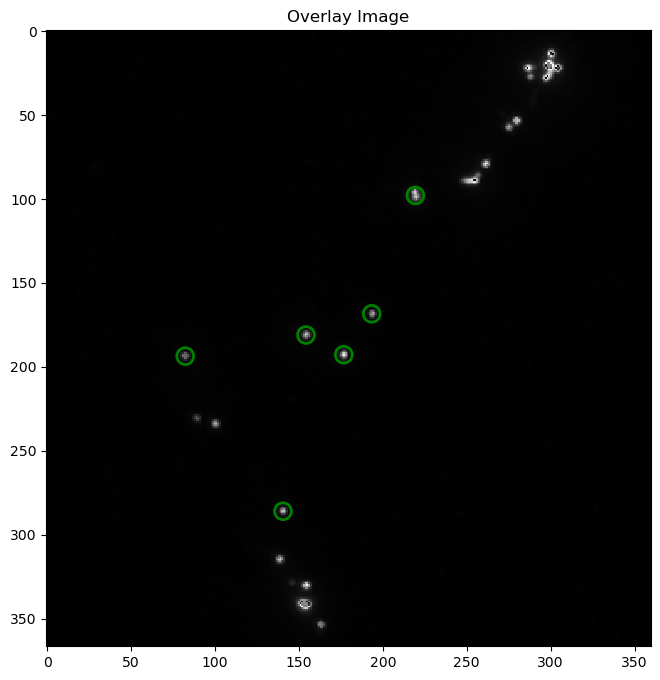

Channel 1 (frame 47)


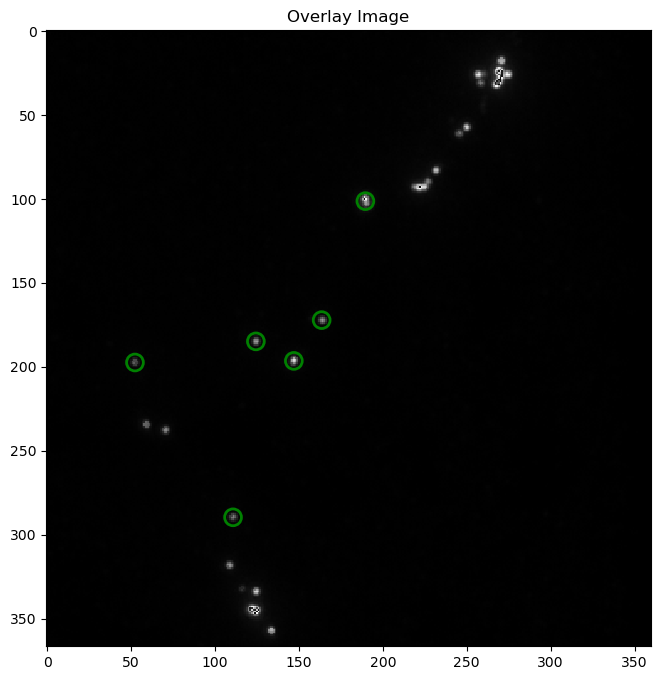

Channel 2 (frame 47)


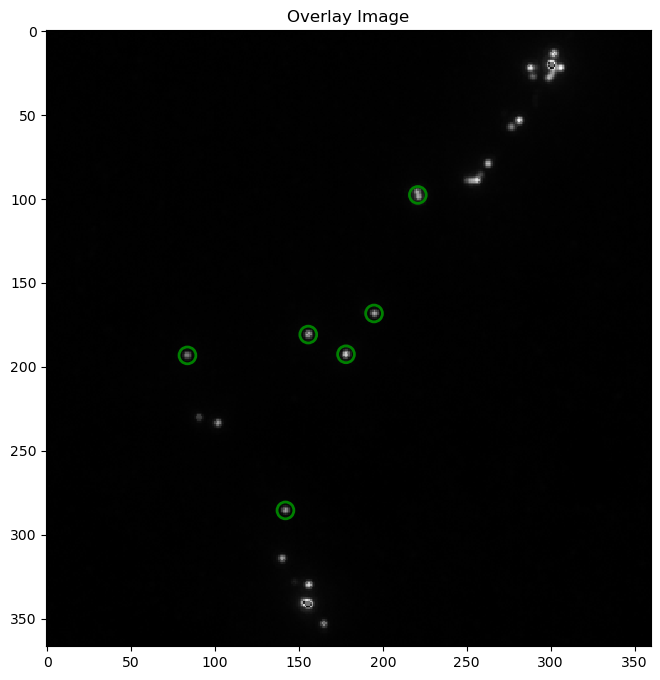

Channel 3 (frame 47)


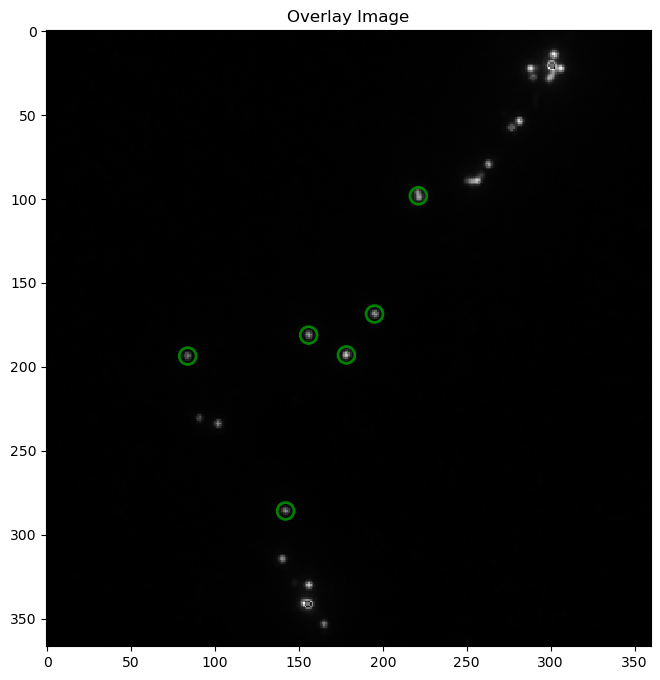

Channel 4 (frame 47)


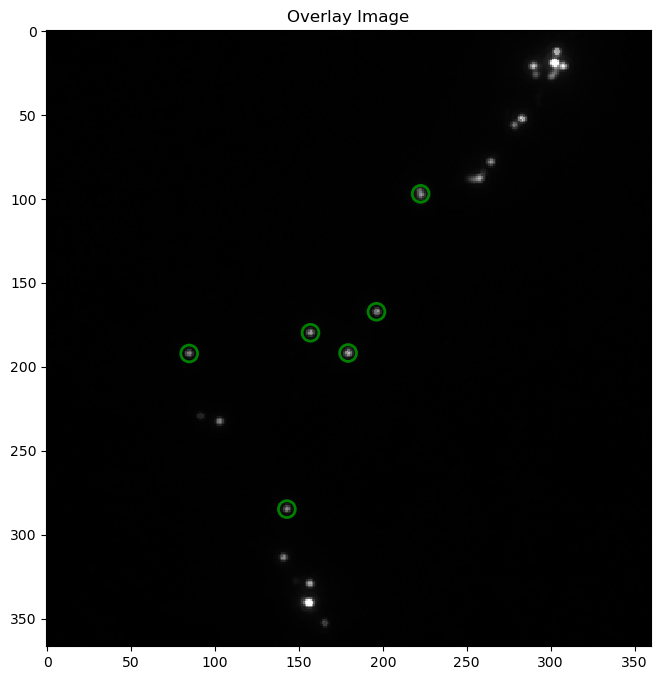

Channel 5 (frame 47)


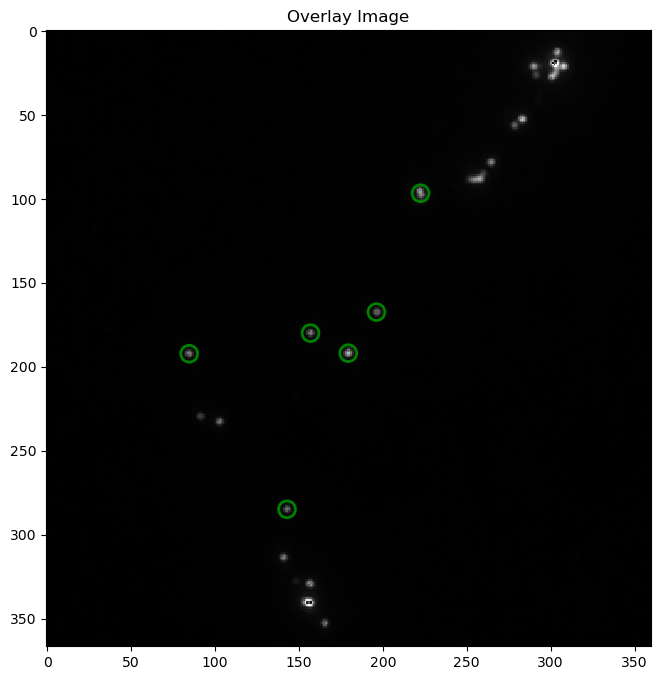

Channel 6 (frame 47)


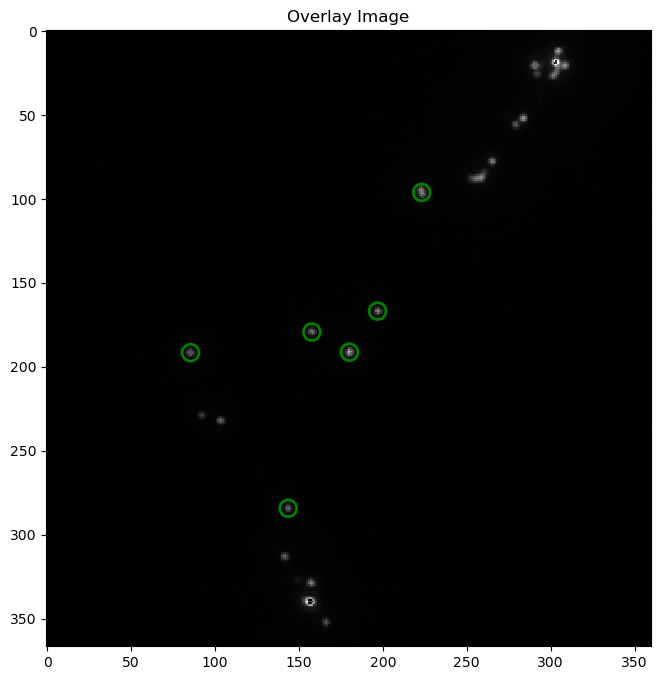

Channel 7 (frame 47)


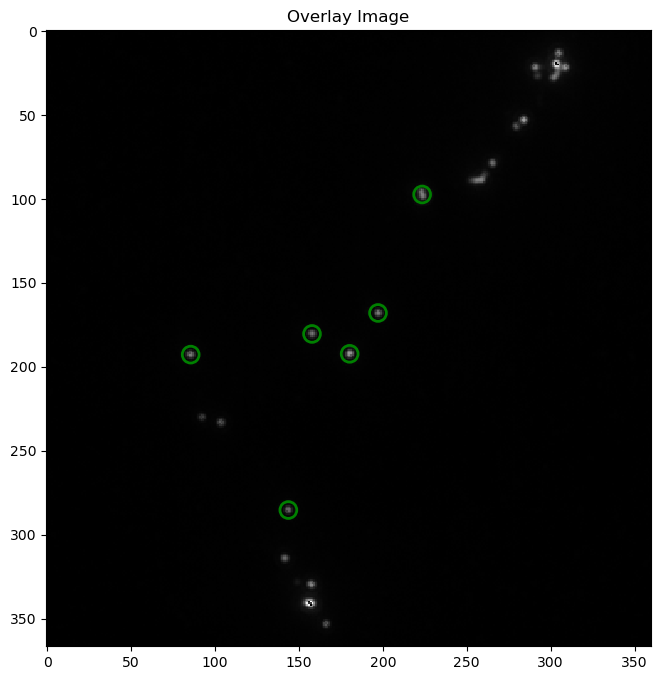

In [38]:
pattern = base_pattern#r'beads_zcal_ch(\d+)\.tif'
beadstack_list = [f for f in os.listdir(root) if re.match(pattern, f)]
psf_locs_list = []
for ii, f in enumerate(beadstack_list):
    id_group = re.match(pattern, f)
    i = int(id_group.group(1))
    check_locs = f"zcal_ch{i}_c{ref_plane+1}_psf.hdf5"
    #check_locs = f"beads_zcal_ch{ref_plane}_c{i}_psf.hdf5"
    #check_locs = f"beads_zcal_ch{i}.hdf5"
    psf_locs_list.append(check_locs)
    
    print(f"Channel {i} (frame {int(mcal['psf_slices']/2)})")
    multiplane_measure_psf.overlayImage(f, check_locs, int(mcal['fp'][ii]))



In [39]:
# investigate psf stack visually in imageJ and run xy drift estimation if necessary
from storm_analysis.multi_plane.zstack_xydrift import xyDrift

for f in psf_locs_list:
    [dx, dy] = xyDrift(f)
    print("dx: {0:5f} dy: {1:5f}".format(dx, dy))

dx: 0.000000 dy: 0.000000
dx: 0.000000 dy: 0.000000
dx: 0.000000 dy: 0.000000
dx: 0.000000 dy: 0.000000
dx: 0.000000 dy: 0.000000
dx: 0.000000 dy: 0.000000
dx: 0.000000 dy: 0.000000
dx: 0.000000 dy: 0.000000


In [40]:
from storm_analysis.multi_plane.psf_zstack import psfZStack  

# needed
pattern = base_pattern #r'beads_zcal_ch(\d+)\.tif'
beadstack_list = [f for f in os.listdir(root) if re.match(pattern, f)]
#psf_locs_list = []

# new, chec if you can use unpaired locs
pattern_locs = r'zcal_ch(\d+)_psf\.hdf5'
plane_locs_list = [f for f in os.listdir(root) if re.match(pattern_locs, f)]
print(f"Plane locs list: {plane_locs_list}")

for f, locs in zip(beadstack_list, psf_locs_list):
#for f, locs in zip(beadstack_list, plane_locs_list):
    print(f"Processing {f}:") 
    id_group = re.match(pattern, f)
    i = int(id_group.group(1))
    psf_stack = f'ch{i+1}_stack'
    psfZStack(f, locs, psf_stack, aoi_size=12)


Plane locs list: []
Processing beads_zcal_ch0.tif:
Processing frame 0
Processing frame 50
Processing frame 100
Processing frame 150
Processing frame 200
Processing frame 250
Processing frame 300
Processing frame 350
Processing frame 400
Processing beads_zcal_ch1.tif:
Processing frame 0
Processing frame 50
Processing frame 100
Processing frame 150
Processing frame 200
Processing frame 250
Processing frame 300
Processing frame 350
Processing frame 400
Processing beads_zcal_ch2.tif:
Processing frame 0
Processing frame 50
Processing frame 100
Processing frame 150
Processing frame 200
Processing frame 250
Processing frame 300
Processing frame 350
Processing frame 400
Processing beads_zcal_ch3.tif:
Processing frame 0
Processing frame 50
Processing frame 100
Processing frame 150
Processing frame 200
Processing frame 250
Processing frame 300
Processing frame 350
Processing frame 400
Processing beads_zcal_ch4.tif:
Processing frame 0
Processing frame 50
Processing frame 100
Processing frame 150


### default offset file in which all slices are valid for all splines

In [41]:
from storm_analysis.spliner.offset_to_z import offsetToZ 


##### Adjust zrange here to individual focal planes and create zdata for each stack
#z_data = np.arange(start=-0.5*mcal['psf_slices']*mcal['dz_stage']/1000, stop=+0.5*mcal['psf_slices']*mcal['dz_stage']/1000, step= mcal['dz_stage']/1000)
z_data = np.arange(start=-0.5*mcal['steps']*mcal['dz_stage']/1000, stop=+0.5*mcal['steps']*mcal['dz_stage']/1000, step= int(mcal['dz_stage'])/1000)
data = np.ones((z_data.size,4))
data[:,3] = z_data

offset_file = 'offset_z_default.txt'
np.savetxt(offset_file, data)
data[:,3]

array([-5.0125, -4.9875, -4.9625, -4.9375, -4.9125, -4.8875, -4.8625,
       -4.8375, -4.8125, -4.7875, -4.7625, -4.7375, -4.7125, -4.6875,
       -4.6625, -4.6375, -4.6125, -4.5875, -4.5625, -4.5375, -4.5125,
       -4.4875, -4.4625, -4.4375, -4.4125, -4.3875, -4.3625, -4.3375,
       -4.3125, -4.2875, -4.2625, -4.2375, -4.2125, -4.1875, -4.1625,
       -4.1375, -4.1125, -4.0875, -4.0625, -4.0375, -4.0125, -3.9875,
       -3.9625, -3.9375, -3.9125, -3.8875, -3.8625, -3.8375, -3.8125,
       -3.7875, -3.7625, -3.7375, -3.7125, -3.6875, -3.6625, -3.6375,
       -3.6125, -3.5875, -3.5625, -3.5375, -3.5125, -3.4875, -3.4625,
       -3.4375, -3.4125, -3.3875, -3.3625, -3.3375, -3.3125, -3.2875,
       -3.2625, -3.2375, -3.2125, -3.1875, -3.1625, -3.1375, -3.1125,
       -3.0875, -3.0625, -3.0375, -3.0125, -2.9875, -2.9625, -2.9375,
       -2.9125, -2.8875, -2.8625, -2.8375, -2.8125, -2.7875, -2.7625,
       -2.7375, -2.7125, -2.6875, -2.6625, -2.6375, -2.6125, -2.5875,
       -2.5625, -2.5

In [42]:
off = offsetToZ(offset_file, dz = -0.5*mcal['steps']*mcal['dz_stage']/1000, all_valid = True)

offset_z_file = 'offset_z.txt'
np.savetxt(offset_z_file, off)
z_offsets = np.loadtxt(offset_z_file)
print(z_offsets)

[[ 1.     -5.0125]
 [ 1.     -4.9875]
 [ 1.     -4.9625]
 [ 1.     -4.9375]
 [ 1.     -4.9125]
 [ 1.     -4.8875]
 [ 1.     -4.8625]
 [ 1.     -4.8375]
 [ 1.     -4.8125]
 [ 1.     -4.7875]
 [ 1.     -4.7625]
 [ 1.     -4.7375]
 [ 1.     -4.7125]
 [ 1.     -4.6875]
 [ 1.     -4.6625]
 [ 1.     -4.6375]
 [ 1.     -4.6125]
 [ 1.     -4.5875]
 [ 1.     -4.5625]
 [ 1.     -4.5375]
 [ 1.     -4.5125]
 [ 1.     -4.4875]
 [ 1.     -4.4625]
 [ 1.     -4.4375]
 [ 1.     -4.4125]
 [ 1.     -4.3875]
 [ 1.     -4.3625]
 [ 1.     -4.3375]
 [ 1.     -4.3125]
 [ 1.     -4.2875]
 [ 1.     -4.2625]
 [ 1.     -4.2375]
 [ 1.     -4.2125]
 [ 1.     -4.1875]
 [ 1.     -4.1625]
 [ 1.     -4.1375]
 [ 1.     -4.1125]
 [ 1.     -4.0875]
 [ 1.     -4.0625]
 [ 1.     -4.0375]
 [ 1.     -4.0125]
 [ 1.     -3.9875]
 [ 1.     -3.9625]
 [ 1.     -3.9375]
 [ 1.     -3.9125]
 [ 1.     -3.8875]
 [ 1.     -3.8625]
 [ 1.     -3.8375]
 [ 1.     -3.8125]
 [ 1.     -3.7875]
 [ 1.     -3.7625]
 [ 1.     -3.7375]
 [ 1.     -3

Psf stack list: ['ch1_stack.npy', 'ch2_stack.npy', 'ch3_stack.npy', 'ch4_stack.npy', 'ch5_stack.npy', 'ch6_stack.npy', 'ch7_stack.npy', 'ch8_stack.npy']
Localisations list: ['zcal_ch0_c1_psf.hdf5', 'zcal_ch1_c1_psf.hdf5', 'zcal_ch2_c1_psf.hdf5', 'zcal_ch3_c1_psf.hdf5', 'zcal_ch4_c1_psf.hdf5', 'zcal_ch5_c1_psf.hdf5', 'zcal_ch6_c1_psf.hdf5', 'zcal_ch7_c1_psf.hdf5']
z plane 0 has 1 samples
z plane 1 has 1 samples
z plane 2 has 1 samples
z plane 3 has 1 samples
z plane 4 has 1 samples
z plane 5 has 1 samples
z plane 6 has 1 samples
z plane 7 has 1 samples
z plane 8 has 1 samples
z plane 9 has 1 samples
z plane 10 has 1 samples
z plane 11 has 1 samples
z plane 12 has 1 samples
z plane 13 has 1 samples
z plane 14 has 1 samples
z plane 15 has 1 samples
z plane 16 has 1 samples
z plane 17 has 1 samples
z plane 18 has 1 samples
z plane 19 has 1 samples
z plane 20 has 1 samples
z plane 21 has 1 samples
z plane 22 has 1 samples
z plane 23 has 1 samples
z plane 24 has 1 samples
z plane 25 has 1 sa

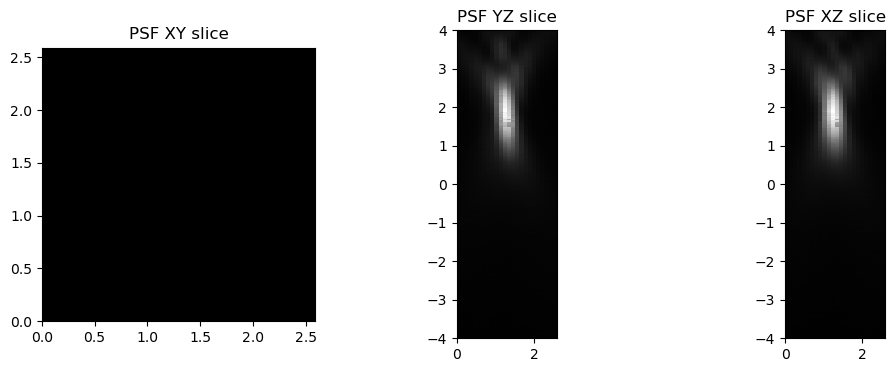

Plots are in microns
z plane 0 has 1 samples
z plane 1 has 1 samples
z plane 2 has 1 samples
z plane 3 has 1 samples
z plane 4 has 1 samples
z plane 5 has 1 samples
z plane 6 has 1 samples
z plane 7 has 1 samples
z plane 8 has 1 samples
z plane 9 has 1 samples
z plane 10 has 1 samples
z plane 11 has 1 samples
z plane 12 has 1 samples
z plane 13 has 1 samples
z plane 14 has 1 samples
z plane 15 has 1 samples
z plane 16 has 1 samples
z plane 17 has 1 samples
z plane 18 has 1 samples
z plane 19 has 1 samples
z plane 20 has 1 samples
z plane 21 has 1 samples
z plane 22 has 1 samples
z plane 23 has 1 samples
z plane 24 has 1 samples
z plane 25 has 1 samples
z plane 26 has 1 samples
z plane 27 has 1 samples
z plane 28 has 1 samples
z plane 29 has 1 samples
z plane 30 has 1 samples
z plane 31 has 1 samples
z plane 32 has 1 samples
z plane 33 has 1 samples
z plane 34 has 1 samples
z plane 35 has 1 samples
z plane 36 has 1 samples
z plane 37 has 1 samples
z plane 38 has 1 samples
z plane 39 has

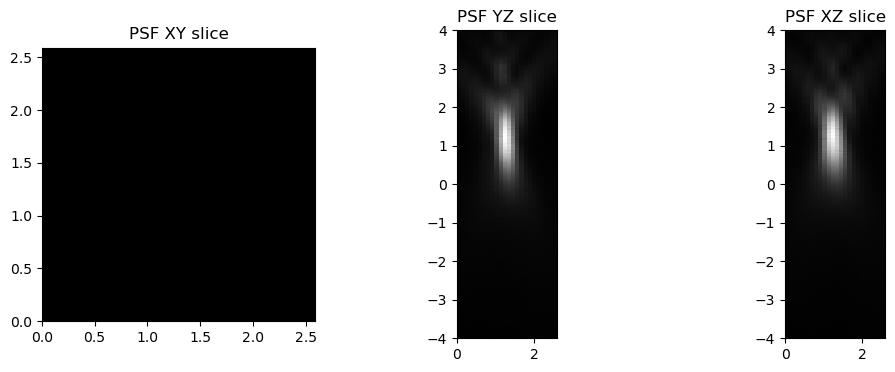

Plots are in microns
z plane 0 has 1 samples
z plane 1 has 1 samples
z plane 2 has 1 samples
z plane 3 has 1 samples
z plane 4 has 1 samples
z plane 5 has 1 samples
z plane 6 has 1 samples
z plane 7 has 1 samples
z plane 8 has 1 samples
z plane 9 has 1 samples
z plane 10 has 1 samples
z plane 11 has 1 samples
z plane 12 has 1 samples
z plane 13 has 1 samples
z plane 14 has 1 samples
z plane 15 has 1 samples
z plane 16 has 1 samples
z plane 17 has 1 samples
z plane 18 has 1 samples
z plane 19 has 1 samples
z plane 20 has 1 samples
z plane 21 has 1 samples
z plane 22 has 1 samples
z plane 23 has 1 samples
z plane 24 has 1 samples
z plane 25 has 1 samples
z plane 26 has 1 samples
z plane 27 has 1 samples
z plane 28 has 1 samples
z plane 29 has 1 samples
z plane 30 has 1 samples
z plane 31 has 1 samples
z plane 32 has 1 samples
z plane 33 has 1 samples
z plane 34 has 1 samples
z plane 35 has 1 samples
z plane 36 has 1 samples
z plane 37 has 1 samples
z plane 38 has 1 samples
z plane 39 has

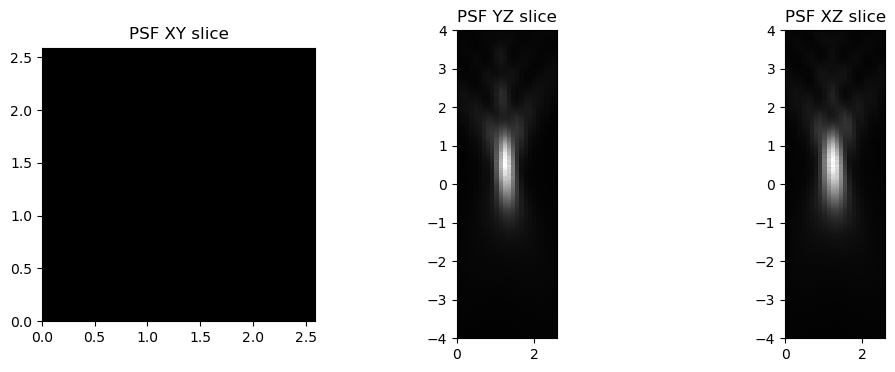

Plots are in microns
z plane 0 has 1 samples
z plane 1 has 1 samples
z plane 2 has 1 samples
z plane 3 has 1 samples
z plane 4 has 1 samples
z plane 5 has 1 samples
z plane 6 has 1 samples
z plane 7 has 1 samples
z plane 8 has 1 samples
z plane 9 has 1 samples
z plane 10 has 1 samples
z plane 11 has 1 samples
z plane 12 has 1 samples
z plane 13 has 1 samples
z plane 14 has 1 samples
z plane 15 has 1 samples
z plane 16 has 1 samples
z plane 17 has 1 samples
z plane 18 has 1 samples
z plane 19 has 1 samples
z plane 20 has 1 samples
z plane 21 has 1 samples
z plane 22 has 1 samples
z plane 23 has 1 samples
z plane 24 has 1 samples
z plane 25 has 1 samples
z plane 26 has 1 samples
z plane 27 has 1 samples
z plane 28 has 1 samples
z plane 29 has 1 samples
z plane 30 has 1 samples
z plane 31 has 1 samples
z plane 32 has 1 samples
z plane 33 has 1 samples
z plane 34 has 1 samples
z plane 35 has 1 samples
z plane 36 has 1 samples
z plane 37 has 1 samples
z plane 38 has 1 samples
z plane 39 has

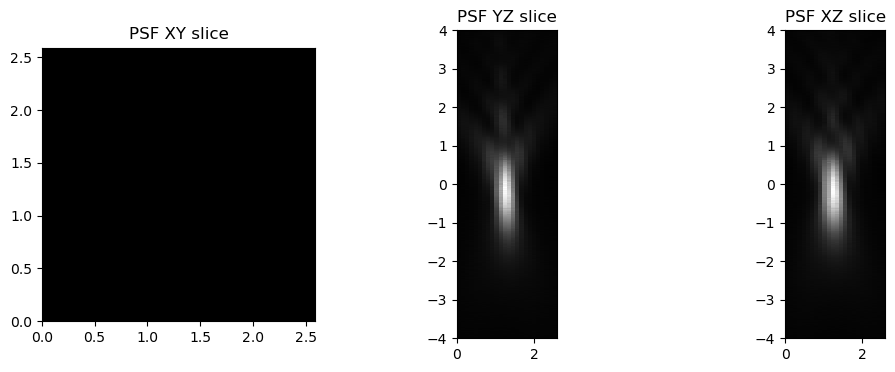

Plots are in microns
z plane 0 has 1 samples
z plane 1 has 1 samples
z plane 2 has 1 samples
z plane 3 has 1 samples
z plane 4 has 1 samples
z plane 5 has 1 samples
z plane 6 has 1 samples
z plane 7 has 1 samples
z plane 8 has 1 samples
z plane 9 has 1 samples
z plane 10 has 1 samples
z plane 11 has 1 samples
z plane 12 has 1 samples
z plane 13 has 1 samples
z plane 14 has 1 samples
z plane 15 has 1 samples
z plane 16 has 1 samples
z plane 17 has 1 samples
z plane 18 has 1 samples
z plane 19 has 1 samples
z plane 20 has 1 samples
z plane 21 has 1 samples
z plane 22 has 1 samples
z plane 23 has 1 samples
z plane 24 has 1 samples
z plane 25 has 1 samples
z plane 26 has 1 samples
z plane 27 has 1 samples
z plane 28 has 1 samples
z plane 29 has 1 samples
z plane 30 has 1 samples
z plane 31 has 1 samples
z plane 32 has 1 samples
z plane 33 has 1 samples
z plane 34 has 1 samples
z plane 35 has 1 samples
z plane 36 has 1 samples
z plane 37 has 1 samples
z plane 38 has 1 samples
z plane 39 has

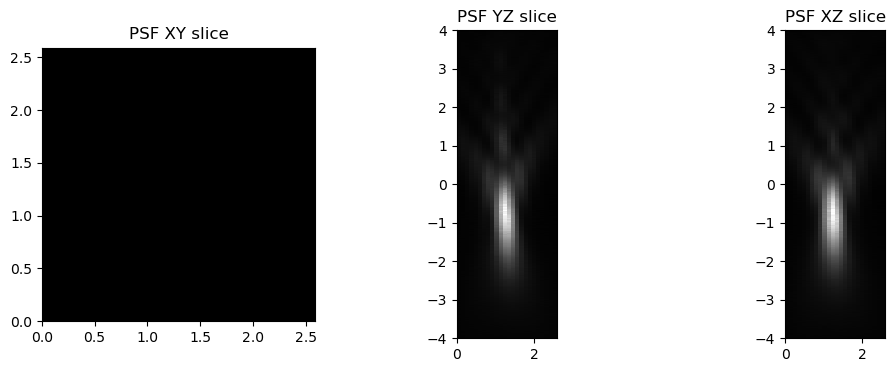

Plots are in microns
z plane 0 has 1 samples
z plane 1 has 1 samples
z plane 2 has 1 samples
z plane 3 has 1 samples
z plane 4 has 1 samples
z plane 5 has 1 samples
z plane 6 has 1 samples
z plane 7 has 1 samples
z plane 8 has 1 samples
z plane 9 has 1 samples
z plane 10 has 1 samples
z plane 11 has 1 samples
z plane 12 has 1 samples
z plane 13 has 1 samples
z plane 14 has 1 samples
z plane 15 has 1 samples
z plane 16 has 1 samples
z plane 17 has 1 samples
z plane 18 has 1 samples
z plane 19 has 1 samples
z plane 20 has 1 samples
z plane 21 has 1 samples
z plane 22 has 1 samples
z plane 23 has 1 samples
z plane 24 has 1 samples
z plane 25 has 1 samples
z plane 26 has 1 samples
z plane 27 has 1 samples
z plane 28 has 1 samples
z plane 29 has 1 samples
z plane 30 has 1 samples
z plane 31 has 1 samples
z plane 32 has 1 samples
z plane 33 has 1 samples
z plane 34 has 1 samples
z plane 35 has 1 samples
z plane 36 has 1 samples
z plane 37 has 1 samples
z plane 38 has 1 samples
z plane 39 has

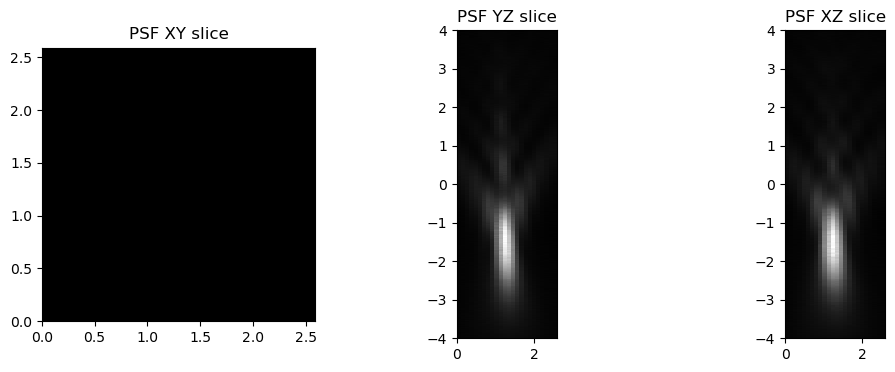

Plots are in microns
z plane 0 has 1 samples
z plane 1 has 1 samples
z plane 2 has 1 samples
z plane 3 has 1 samples
z plane 4 has 1 samples
z plane 5 has 1 samples
z plane 6 has 1 samples
z plane 7 has 1 samples
z plane 8 has 1 samples
z plane 9 has 1 samples
z plane 10 has 1 samples
z plane 11 has 1 samples
z plane 12 has 1 samples
z plane 13 has 1 samples
z plane 14 has 1 samples
z plane 15 has 1 samples
z plane 16 has 1 samples
z plane 17 has 1 samples
z plane 18 has 1 samples
z plane 19 has 1 samples
z plane 20 has 1 samples
z plane 21 has 1 samples
z plane 22 has 1 samples
z plane 23 has 1 samples
z plane 24 has 1 samples
z plane 25 has 1 samples
z plane 26 has 1 samples
z plane 27 has 1 samples
z plane 28 has 1 samples
z plane 29 has 1 samples
z plane 30 has 1 samples
z plane 31 has 1 samples
z plane 32 has 1 samples
z plane 33 has 1 samples
z plane 34 has 1 samples
z plane 35 has 1 samples
z plane 36 has 1 samples
z plane 37 has 1 samples
z plane 38 has 1 samples
z plane 39 has

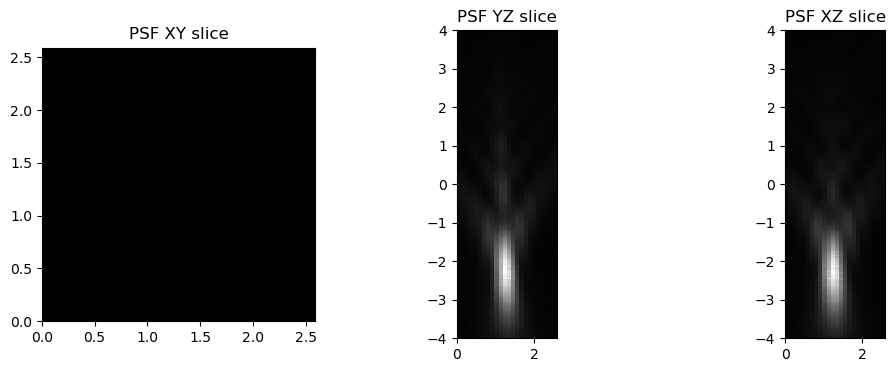

Plots are in microns
z plane 0 has 1 samples
z plane 1 has 1 samples
z plane 2 has 1 samples
z plane 3 has 1 samples
z plane 4 has 1 samples
z plane 5 has 1 samples
z plane 6 has 1 samples
z plane 7 has 1 samples
z plane 8 has 1 samples
z plane 9 has 1 samples
z plane 10 has 1 samples
z plane 11 has 1 samples
z plane 12 has 1 samples
z plane 13 has 1 samples
z plane 14 has 1 samples
z plane 15 has 1 samples
z plane 16 has 1 samples
z plane 17 has 1 samples
z plane 18 has 1 samples
z plane 19 has 1 samples
z plane 20 has 1 samples
z plane 21 has 1 samples
z plane 22 has 1 samples
z plane 23 has 1 samples
z plane 24 has 1 samples
z plane 25 has 1 samples
z plane 26 has 1 samples
z plane 27 has 1 samples
z plane 28 has 1 samples
z plane 29 has 1 samples
z plane 30 has 1 samples
z plane 31 has 1 samples
z plane 32 has 1 samples
z plane 33 has 1 samples
z plane 34 has 1 samples
z plane 35 has 1 samples
z plane 36 has 1 samples
z plane 37 has 1 samples
z plane 38 has 1 samples
z plane 39 has

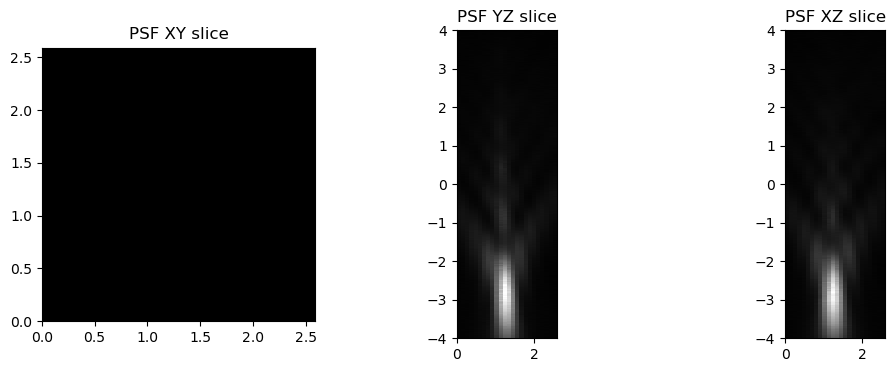

Plots are in microns


['ch1_psf.psf',
 'ch2_psf.psf',
 'ch3_psf.psf',
 'ch4_psf.psf',
 'ch5_psf.psf',
 'ch6_psf.psf',
 'ch7_psf.psf',
 'ch8_psf.psf']

In [43]:
from storm_analysis.multi_plane.measure_psf import measurePSF
import storm_analysis.jupyter_examples.psf_images as psfImages

pattern = r'ch(\d+)_stack\.npy' 
psf_stack_list = [f for f in os.listdir(root) if re.match(pattern, f)]
print(f"Psf stack list: {psf_stack_list}")
print(f"Localisations list: {psf_locs_list}")
psf_names = []

for st, loc in zip(psf_stack_list, psf_locs_list):
#for st, loc in zip(psf_stack_list, plane_locs_list):
    idgroup = re.match(pattern, st)
    psf_name = f'ch{idgroup.group(1)}_psf.psf'
    psf_names.append(psf_name)
    
    measurePSF(st, 
               offset_z_file, 
               psf_name,  
                pixel_size = pixel_size * 1.0e-3, 
                z_range = np.abs(spline_z_range), #0.75 
                z_step = np.abs(int(mcal['dz_stage'])/1000))

    psfImages.psfImages(psf_name)

psf_names

### adaptive offset file in which only appropriate psf slices are valid 
* limit valid z slices to +- 1um? of the PSF

In [ ]:
from storm_analysis.spliner.offset_to_z import offsetToZ 
from storm_analysis.multi_plane.measure_psf import measurePSF
import storm_analysis.jupyter_examples.psf_images as psfImages
splice_range = 1800 # nm
##### Adjust zrange here to individual focal planes and create zdata for each stack
z_data = np.arange(start=-0.5*mcal['steps']*np.abs(np.rint(mcal['dz_stage']))/1000, stop=+0.5*mcal['steps']*np.abs(np.rint(mcal['dz_stage']))/1000, step= np.abs(np.rint(mcal['dz_stage']))/1000) # whole stack zdata 

pattern = r'ch(\d+)_stack.npy' 
psf_stack_list = [f for f in os.listdir(root) if re.match(pattern, f)]
print(f"PSF stack list: {psf_stack_list}")
nplanes = len(psf_stack_list)
psf_names = []

#for st, loc in zip(psf_stack_list, plane_locs_list):  # for each psf stack create a z_offset file   
for st in psf_stack_list:  
    idgroup = re.match(pattern, st)
    ix = int(idgroup.group(1))-1  # index of the focal plane in the mcal['fp'] list, needs adjusting for python indexing 

    # select indices that are within the zlim range of the focal plane 
    zlim = [ np.max([mcal['fp'][ix] - int(splice_range/dz), 0]), np.min([mcal['fp'][ix] + int(splice_range/dz), mcal['steps']-1]) ]

    plane_z_data = z_data.copy() # copy whole z_data range for the current focal plane
    # set values outside the zlim range to the center value of that plane so they do no affect the min-max range that is conducted in the offsetToZ function
    plane_z_data[:zlim[0]] = z_data[mcal['fp'][ix]]
    plane_z_data[zlim[1]:] = z_data[mcal['fp'][ix]]

    data = np.ones((z_data.size,4))
    data[:,3] = plane_z_data #z_data

    # create offset file for each stack
    offset_file_raw = f'offset_z_ch{idgroup.group(1)}_raw.txt'
    np.savetxt(offset_file_raw, data)

    dz_offset = (0.5*mcal['steps'] - mcal['fp'][ix]) * mcal['dz_stage']/1000

    off = offsetToZ(offset_file_raw, dz = 0, all_valid = False)
    off[:,1] = z_data[:-1] # overwrite limit range manipulation to use the whole z_data range in display, only valid values are now taken by the psf creation
    offset_z_file = f'offset_z_ch{idgroup.group(1)}.txt'
    np.savetxt(offset_z_file, off)
    z_offsets = np.loadtxt(offset_z_file)
    print(f"Z offsets in {offset_z_file}:")
    print(z_offsets)

    print(f"Processing {st}:")
    # create psf name
    psf_name = f'ch{idgroup.group(1)}_psf.psf'
    psf_names.append(psf_name)

    measurePSF(st, 
            offset_z_file, 
            psf_name,  
            pixel_size = pixel_size * 1.0e-3, 
            z_range = np.rint(0.5*mcal['steps'])*np.abs(np.rint(mcal['dz_stage']))/1000,#  nplanes*splice_range/1000, #0.75 
            z_step = np.abs(np.rint(mcal['dz_stage']))/1000)

    psfImages.psfImages(psf_name)

psf_names

## Normalize PSFs

In [44]:
from storm_analysis.multi_plane.normalize_psfs import normalizePSFs
  
normalizePSFs(psf_names)
# create filelist
pattern = r'ch(\d+)_psf_normed\.psf' 
psf_names_normed  = [f for f in os.listdir(root) if re.match(pattern, f)]


ch1_psf_normed.psf 1.0
ch2_psf_normed.psf 0.8822571596871175
ch3_psf_normed.psf 0.9369226562696684
ch4_psf_normed.psf 0.875655527080195
ch5_psf_normed.psf 0.8600413209190202
ch6_psf_normed.psf 0.6850797831376337
ch7_psf_normed.psf 0.7036291042145345
ch8_psf_normed.psf 0.7148099783494928


### check plane offsets 
zrange should cover the flanks of the outer PSFs

In [45]:
import matplotlib.pyplot as pyplot
import numpy


def checkPlaneOffsets_KG(psf_files):

    psfs = []
    for psf_file in psf_files:
        with open(psf_file, 'rb') as fp:
            psfs.append(pickle.load(fp))
        
    fig = pyplot.figure()

    plots = []
    max_vals = []
    for i, psf in enumerate(psfs):
        ave_psf = psf["psf"]
        zvals = psf["zvals"]

        max_i = numpy.amax(ave_psf, axis = (1,2))
        tmp, = pyplot.plot(zvals, max_i, label = psf_files[i])
        plots.append(tmp)

        n_max = numpy.argmax(max_i)
        print("Plane: {0:0d} maximum at {1:.1f}nm".format(i, zvals[n_max]))
        max_vals.append(zvals[n_max])

    pyplot.legend(handles = plots, loc = 1)
    pyplot.ylim((0.0,1.5))
    pyplot.xlabel("Z offset (nm)")
    pyplot.ylabel("PSF Max (AU)")
    pyplot.show()   
    return max_vals

Plane: 0 maximum at -1900.0nm
Plane: 1 maximum at -1300.0nm
Plane: 2 maximum at -600.0nm
Plane: 3 maximum at 100.0nm
Plane: 4 maximum at 675.0nm
Plane: 5 maximum at 1375.0nm
Plane: 6 maximum at 2275.0nm
Plane: 7 maximum at 2825.0nm


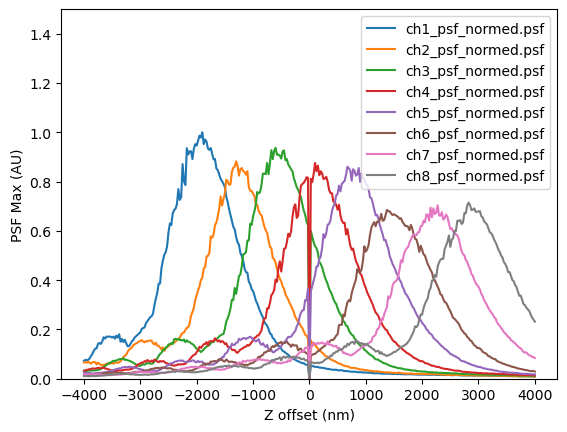

In [46]:
from storm_analysis.multi_plane.check_plane_offsets import checkPlaneOffsets
#checkPlaneOffsets(psf_names_normed)
z_value_psfs = checkPlaneOffsets_KG(psf_names_normed)


### PSF to spline conversion
check everything beforehand, takes quite some time 

In [26]:
import storm_analysis.spliner.psf_to_spline as psfToSpline

In [27]:

psf_names_spline = []
for i, f in enumerate(psf_names_normed):
    spline_name = f.replace('_normed.psf', '.spline') 
    psf_names_spline.append(spline_name)
    
    print(f'Creating spline {spline_name}')
    # 10 is 1/2 the spline size in pixels. This is reasonable value for setups with a camera pixel size of 100nm.    
    psfToSpline.psfToSpline(f, spline_name, 10)

Creating spline ch1_psf.spline
Generating 3D spline.
Generating XY splines.
Generating fitting spline.
Calculating spline coefficients.
Calculating spline values.
  0 of 19
  1 of 19
  2 of 19
  3 of 19
  4 of 19
  5 of 19
  6 of 19
  7 of 19
  8 of 19
  9 of 19
  10 of 19
  11 of 19
  12 of 19
  13 of 19
  14 of 19
  15 of 19
  16 of 19
  17 of 19
  18 of 19
  19 of 19
  cx 0.00 19
  cx 0.33 19
  cx 0.67 19
  cx 1.00 19
  cx 1.33 19
  cx 1.67 19
  cx 2.00 19
  cx 2.33 19
  cx 2.67 19
  cx 3.00 19
  cx 3.33 19
  cx 3.67 19
  cx 4.00 19
  cx 4.33 19
  cx 4.67 19
  cx 5.00 19
  cx 5.33 19
  cx 5.67 19
  cx 6.00 19
  cx 6.33 19
  cx 6.67 19
  cx 7.00 19
  cx 7.33 19
  cx 7.67 19
  cx 8.00 19
  cx 8.33 19
  cx 8.67 19
  cx 9.00 19
  cx 9.33 19
  cx 9.67 19
  cx 10.00 19
  cx 10.33 19
  cx 10.67 19
  cx 11.00 19
  cx 11.33 19
  cx 11.67 19
  cx 12.00 19
  cx 12.33 19
  cx 12.67 19
  cx 13.00 19
  cx 13.33 19
  cx 13.67 19
  cx 14.00 19
  cx 14.33 19
  cx 14.67 19
  cx 15.00 19
  cx 15.33 19

### Plane weights
Multiplane uses channel “information” weights in order to more optimally weight the contribution from each plane in the determination of a localizations parameters. The channels are weighted based on their Cramer-Rao bounds as a function of z.

For this step you will need a reasonable estimate of the average background and intensity in the data you plan to analyze. The background is photo-electrons per plane. The signal is the expected average number of photo-electrons per localization summed over all the planes. If your camera does not have a gain of 1.0 you will need to convert camera counts to photo-electrons.

Ideally the analysis would update the Cramer-Rao bounds for each localization as the estimates for the background and intensity change. However as the Cramer-Rao calculation is somewhat computational expensive we forego this step and instead just use average values.

In [28]:
psf_names_spline = [f for f in os.listdir(root) if f.endswith('.spline')]
psf_names_spline

['ch1_psf.spline',
 'ch2_psf.spline',
 'ch3_psf.spline',
 'ch4_psf.spline',
 'ch5_psf.spline',
 'ch6_psf.spline',
 'ch7_psf.spline',
 'ch8_psf.spline']

In [29]:
# first create final analysis file
import storm_analysis.sa_library.parameters as parameters

def multiplaneXML(spline_names, spline_z_range, z_value, params_name):
    """
    Create a Multiplane parameters object.
    """
    params = parameters.ParametersMultiplaneArb()

    params.setAttr("max_frame", "int", -1)    
    params.setAttr("start_frame", "int", -1)

    #params.setAttr("verbosity", "int", 100) # interval of frames displayed during fitting
    params.setAttr("verbosity", "int", 1) # interval of frames displayed during fitting

    params.setAttr("background_sigma", "float", 9.0)
    #params.setAttr("foreground_sigma", "float", 3.0)
    params.setAttr("find_max_radius", "int", 10)
    params.setAttr("independent_heights", "int", 0) # 1: multicolor spectral demixing, 0: single color
    params.setAttr("iterations", "int", 1) # 20 for regular fitting, 1 for beads to avoid spurious splitting
    params.setAttr("mapping", "filename", "merged_map.map")
    params.setAttr("no_fitting", "int", 0)
    #params.setAttr("roi_size", "int", 35)
    params.setAttr("pixel_size", "float", pixel_size)
    # Convert from FWHM in nanometers to sigma in pixels.
    params.changeAttr("sigma", 380/(100.0 * 2.355))
    #params.setAttr("sigma", "float", 2) # 1.5
    params.setAttr("threshold", "float",25.0) #11.0
    params.setAttr("weights", "filename", "weights.npy")
    params.setAttr("z_value", "float-array", z_value)

    # try from https://storm-analysis.readthedocs.io/_/downloads/en/latest/pdf/ / model parameter
    #params.setAttr("model", "string", "3d") # “2dfixed”, “2d”, “3d”, or “Z”

    for i, f in enumerate(spline_names):
        params.setAttr(f"spline{i}", "filename", f)
        #params.setAttr(f"psf{i}", "filename", f)
        
        #params.setAttr(f"channel{i}_cal", "filename", f"calib_{i}.npy")
        params.setAttr(f"channel{i}_cal", "filename", f"calib_dummy_{i}.npy")

        #params.setAttr(f"channel{i}_ext", "string", f"pl{i}.tif") # fileextension to define plane
        params.setAttr(f"channel{i}_ext", "string", f"ch{i}.tif") # fileextension to define plane

        params.setAttr(f"channel{i}_offset", "int", 0)

    # Don't do tracking.
    params.setAttr("descriptor", "string", "1")
    params.setAttr("radius", "float", "0.0")

    params.setAttr("max_z", "float", str(1.2*spline_z_range + 0.001))
    params.setAttr("min_z", "float", str(-(1.2*spline_z_range - 0.001)))

    # Don't do drift-correction.
    params.setAttr("d_scale", "int", 2)
    params.setAttr("drift_correction", "int", 0)
    params.setAttr("frame_step", "int", 500)
    params.setAttr("z_correction", "int", 0)

    # procedural
    #params.setAttr("convert_to ", "string", ".txt")
    #params.setAttr("fftw_estimate  ", "int", 1)
    # assuming EMCCD instead of custom sCMOS calibration
    #params.setAttr("camera_gain", "float", 0.23)
    #params.setAttr("camera_offset", "float", 100.0)

    params.toXMLFile(params_name)


if 'z_value_psfs' in locals():  # use psf max based offsets if available
    print(f"Using psf max based offsets: {z_value_psfs}")
    z_value = [zz/1000 for zz in z_value_psfs]
else:
    print(f"Using stage based offsets: {(0.5*mcal['steps'] - np.array(mcal['fp'])) * mcal['dz_stage']/1000}")
    z_value =  [(0.5*mcal['steps'] - mcal['fp'][ix]) * mcal['dz_stage']/1000 for ix in range(len(mcal['fp']))]

#z_value =  [-(0.5*mcal['steps'] - mcal['fp'][ix]) * mcal['dz_stage']/1000 for ix in range(len(mcal['fp']))]
print(f"Using: {z_value}")

multiplane_params = 'validation_multiplane.xml'
multiplaneXML(psf_names_spline, np.abs(spline_z_range), z_value, multiplane_params)
#multiplaneXML(psf_names_normed, np.abs(spline_z_range), z_value, multiplane_params)  # with psf stacks instead of spline, need to change params.setAttr(f"spline{i}", "filename", f) to psf{i}


Using psf max based offsets: [-2009.0, -1617.0, -833.0, -343.0, 392.0, 1176.0, 1813.0, 2499.0]
Using: [-2.009, -1.617, -0.833, -0.343, 0.392, 1.176, 1.813, 2.499]


In [30]:
psf_names_spline

['ch1_psf.spline',
 'ch2_psf.spline',
 'ch3_psf.spline',
 'ch4_psf.spline',
 'ch5_psf.spline',
 'ch6_psf.spline',
 'ch7_psf.spline',
 'ch8_psf.spline']

Calculating Cramer-Rao bounds.
z -3920.0
z -3507.4
z -3094.7
z -2682.1
z -2269.5
z -1856.8
z -1444.2
z -1031.6
z -618.9
z -206.3
z 206.3
z 618.9
z 1031.6
z 1444.2
z 1856.8
z 2269.5
z 2682.1
z 3094.7
z 3507.4
z 3920.0
Correcting for mapping.


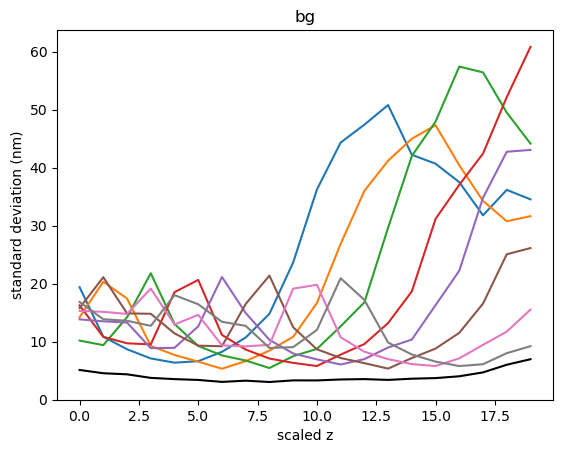

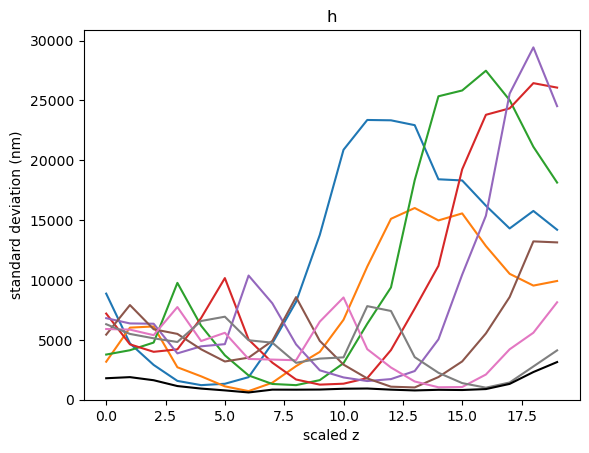

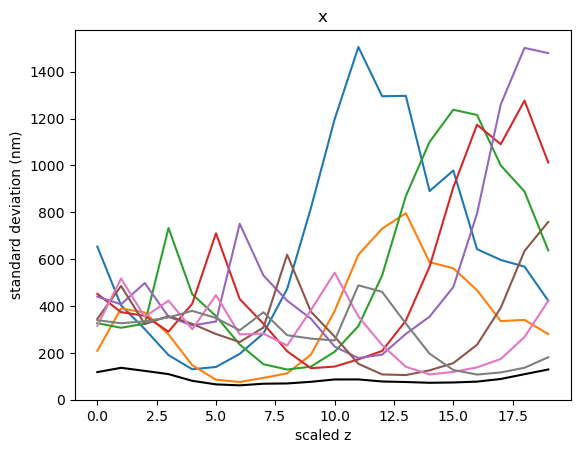

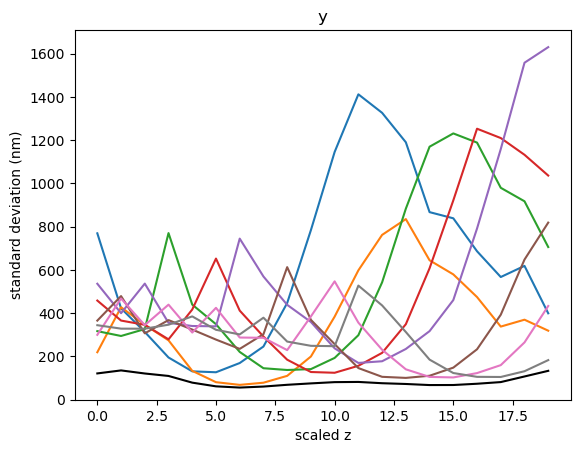

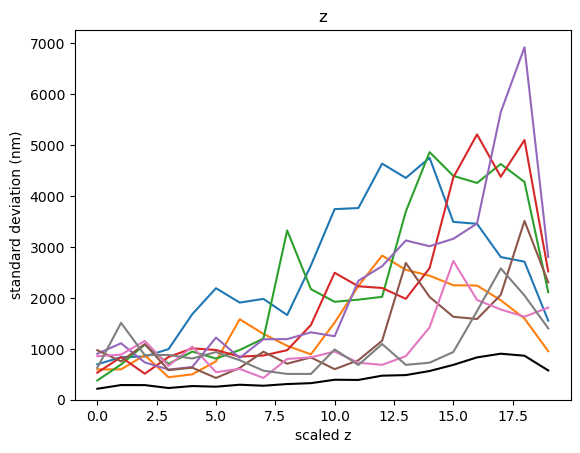

In [31]:
import storm_analysis.multi_plane.plane_weighting as planeWeighting
'''
def runPlaneWeighting(xml, output, background, photons, no_plots = False):
    xml - The analysis XML file.
    output - File name to save the weights in.
    background - Per pixel background in e- for each plane (as a list).
    photons - Integrated peak intensity in e-.
    no_plots - Don't show any plots.
'''
background = [7500 for _ in psf_names_spline]
#background = [200 for _ in psf_names_spline]

planeWeighting.runPlaneWeighting(multiplane_params, 
                                 "weights.npy",
                                 background,   # 20 photons average background in each plane
                                 20000,       # 2000 photon average PSF sum.
                                 no_plots = False)


# Run the analysis

In [ ]:
# parse the raw_data filelist
#filekey = r'A1_vim680_silicone_demag2_3_MMStack_Pos0_f(\d+)_'
filekey = r'beads_zcal_(\d+)'


indices = [re.match(filekey, f).group(1) for f in os.listdir(root+r"\data") if re.match(filekey, f)]
indices = natsorted(np.unique(indices))
print(f"Unique file indices: {indices}")

In [ ]:
# batch run all subfiles
import storm_analysis.multi_plane.multi_plane as mp
import storm_analysis.sa_utilities.hdf5_to_txt as txt_conv
import storm_analysis.sa_utilities.hdf5_to_image as img_conv

t = tqdm(total=len(indices), desc="Filename")
subfolder = r"data"

for index in indices:
    basename = filekey.replace(r"(\d+)", index)
    basename_folder = os.path.join(subfolder, basename)
    #mlist_name = f"multiplane_locfit_{index}.hdf5"
    mlist_name = os.path.join(subfolder, f"multiplane_locfit_{index}.hdf5")

    print(f"Processing {basename_folder} to file {mlist_name}")

    mp.analyze(basename_folder, mlist_name, multiplane_params)

    # write loc files to txt
    txtname = mlist_name.replace('.hdf5', '.txt')
    txt_conv.hdf5ToTxt(mlist_name, txtname)

    # convert localisation coordinates from pixel to nm
    txtname = mlist_name.replace('.hdf5', '_pxl2nm.txt')
    print(f"Writing to {txtname}")
    hdf5PxlToTxtNm(mlist_name, txtname, pixel_size)

    # convert to csv
    txt2csv(txtname)

    t.update(1)

print(f"Finished processing {root}")

## backup single file processing

In [45]:
#basename = os.path.join(r"data", "corrected_beads_zcal_") 
basename = "beads_zcal_"
#mlist_name = r'8plane_A1_vim680_silicone.bin'
if not os.path.exists(r'results'):
    os.makedirs(r'results')
mlist_name = os.path.join(r"results", r'_validation_v0.hdf5') 

print(f"Processing {basename} to file {mlist_name} in {root}")

Processing beads_zcal_ to file results\_validation_v0.hdf5 in D:\moritz\Technical_paper\202508_smlm_test\CS4_e642nm_kinetix2_dz25_3\cal_data


In [46]:
import storm_analysis.multi_plane.multi_plane as mp
mp.analyze(basename, mlist_name, multiplane_params)

weights z scaling - offset: 0.000 scale: 1.000
Found data for 8 planes.

version 2023.02.26

Peak finding
Frame: 0 28 28
Frame: 1 26 54
Frame: 2 24 78
Frame: 3 29 107
Frame: 4 30 137
Frame: 5 26 163
Frame: 6 30 193
Frame: 7 29 222
Frame: 8 31 253
Frame: 9 31 284
Frame: 10 37 321
Frame: 11 34 355
Frame: 12 31 386
Frame: 13 33 419
Frame: 14 38 457
Frame: 15 36 493
Frame: 16 38 531
Frame: 17 37 568
Frame: 18 34 602
Frame: 19 37 639
Frame: 20 34 673
Frame: 21 35 708
Frame: 22 35 743
Frame: 23 32 775
Frame: 24 34 809
Frame: 25 31 840
Frame: 26 36 876
Frame: 27 32 908
Frame: 28 33 941
Frame: 29 32 973
Frame: 30 35 1008
Frame: 31 32 1040
Frame: 32 31 1071
Frame: 33 30 1101
Frame: 34 32 1133
Frame: 35 36 1169
Frame: 36 34 1203
Frame: 37 34 1237
Frame: 38 32 1269
Frame: 39 36 1305
Frame: 40 39 1344
Frame: 41 38 1382
Frame: 42 35 1417
Frame: 43 35 1452
Frame: 44 39 1491
Frame: 45 37 1528
Frame: 46 36 1564
Frame: 47 34 1598
Frame: 48 32 1630
Frame: 49 32 1662
Frame: 50 30 1692
Frame: 51 32 1724
F

## visualiser
cd storm_analysis.visualizer

python visualizer.py 

## data conversion

In [47]:
import storm_analysis.sa_utilities.hdf5_to_txt as txt_conv
txtname = mlist_name.replace('.hdf5', '.txt')
txt_conv.hdf5ToTxt(mlist_name, txtname)

Converting localizations.


In [48]:
# convert localisation coordinates from pixel to nm
txtname = mlist_name.replace('.hdf5', '_pxl2nm.txt')
print(f"Writing to {txtname}")
hdf5PxlToTxtNm(mlist_name, txtname, pixel_size)

Writing to results\_validation_v0_pxl2nm.txt
Converting localizations.


401it [00:05, 67.58it/s]


Tracks not found, using localizations.
.


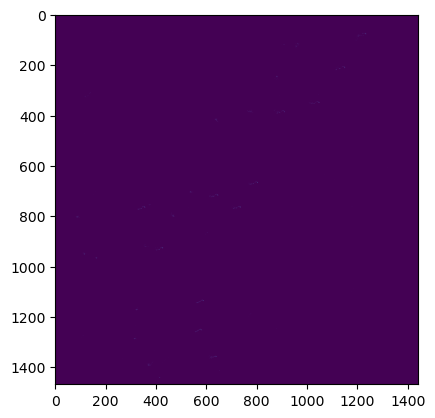

In [49]:
import storm_analysis.sa_utilities.hdf5_to_image as img_conv

tiffname = mlist_name.replace('.hdf5', '.tiff')
img2d = img_conv.render2DImage(mlist_name, scale = 4)
plt.imshow(img2d)

Tracks not found, using localizations.
.


(367, 360)

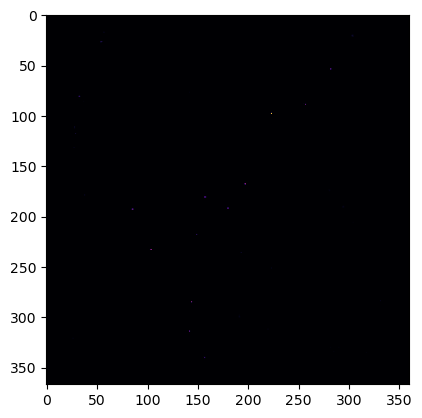

In [50]:
img3d = img_conv.render3DImage(mlist_name, z_edges= [-0.1, 0.1] , scale = 1)
plt.imshow(img3d[0], cmap='inferno')
img3d[0].shape


In [51]:
txt2csv(txtname)

Finished writing results\_validation_v0_pxl2nm.csv


In [52]:
import pandas as pd

locs = pd.read_csv(txtname, sep=',', header=0, index_col=0)
locs.head(10)

,frame,background,c1_background,c1_error,c1_height,c1_iterations,c1_significance,c1_sum,c1_x,c1_y,...,height,iterations,significance,sum,x,y,z,xnm,ynm,znm
index,,,,,,,,,,,,,,,,,,,,,
0,0,121.388,803.954,10212.521,204.823,11,39.466,3964.735,268.644,27.617,...,204.823,11,39.466,4113.877,239.015,31.533,-1.494,25813.635,3405.550,-161.305
1,0,973.114,90.678,2334.249,325.465,28,26.035,4396.233,323.143,39.707,...,325.465,28,26.035,7709.379,293.612,43.543,-2.869,31710.100,4702.664,-309.824
2,0,350.892,600.561,17309.206,256.709,32,49.255,5075.849,280.149,50.943,...,256.709,32,49.255,5286.999,250.544,54.803,-1.608,27058.719,5918.689,-173.660
3,0,319.312,369.665,7553.712,405.058,45,52.701,6947.055,250.481,89.451,...,405.058,45,52.701,9769.737,220.827,93.269,-2.563,23849.357,10073.008,-276.752
4,0,376.949,86.757,1347.040,419.931,17,45.650,6039.842,299.502,91.749,...,419.931,17,45.650,10079.892,269.936,95.511,-2.800,29153.062,10315.155,-302.443
5,0,261.276,56.870,1505.794,566.539,27,88.220,9256.771,204.573,185.477,...,566.539,27,88.220,13567.477,174.850,189.160,-2.636,18883.799,20429.303,-284.723
6,0,213.980,84.354,1434.272,286.469,19,46.204,4796.988,224.090,184.428,...,286.469,19,46.204,6901.196,194.402,188.093,-2.605,20995.376,20314.017,-281.360
7,0,200.850,130.642,3396.954,117.245,15,32.847,2381.049,136.557,223.223,...,117.245,15,32.847,2492.509,106.718,226.906,-1.783,11525.517,24505.862,-192.556
8,0,483.683,71.345,3344.544,479.616,44,85.717,9648.037,201.167,331.449,...,479.616,44,85.717,10935.544,171.456,334.858,-2.157,18517.232,36164.674,-233.002


Text(0, 0.5, 'z (um)')

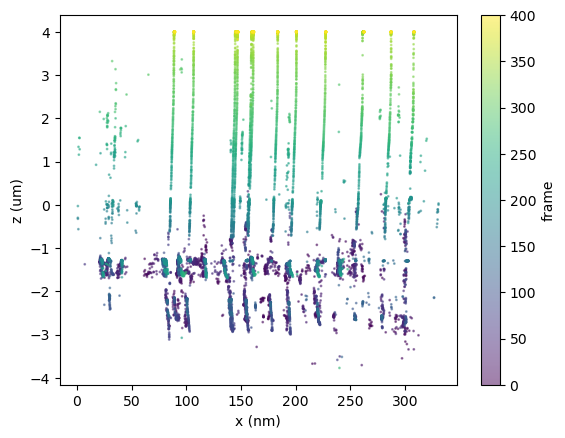

In [53]:
plt.scatter(locs['x'], locs['z'], c=locs['frame'], s=1, alpha=0.5)
plt.colorbar(label='frame')
plt.xlabel('x (nm)')
plt.ylabel('z (um)')

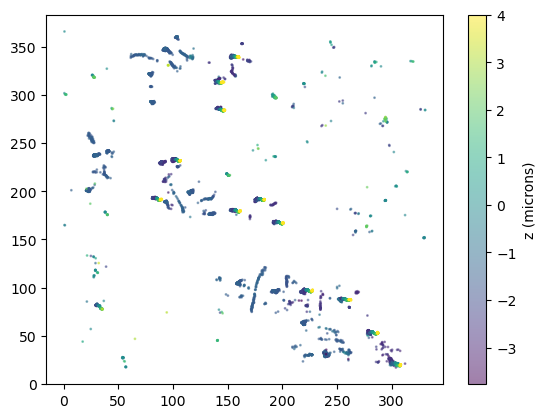

In [54]:
plt.scatter(locs['x'], locs['y'], c=locs['z'], s=1, alpha=0.5)
plt.colorbar(label='z (microns)')

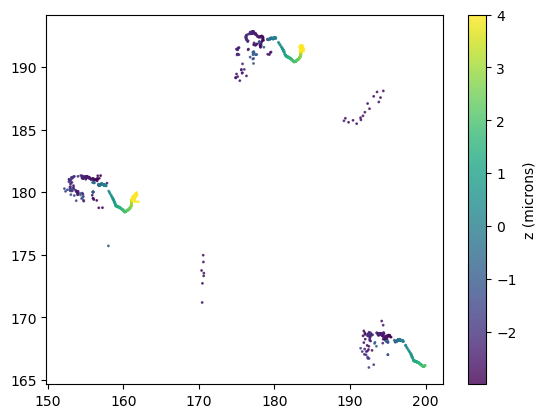

In [57]:
locs_bead = locs[(locs['x'] > 150) & (locs['x'] < 200) & (locs['y'] > 150) & (locs['y'] < 200)]
plt.scatter(locs_bead['x'], locs_bead['y'], c=locs_bead['z'], s=1, alpha=0.8)
plt.colorbar(label='z (microns)')

Text(0, 0.5, 'z (um)')

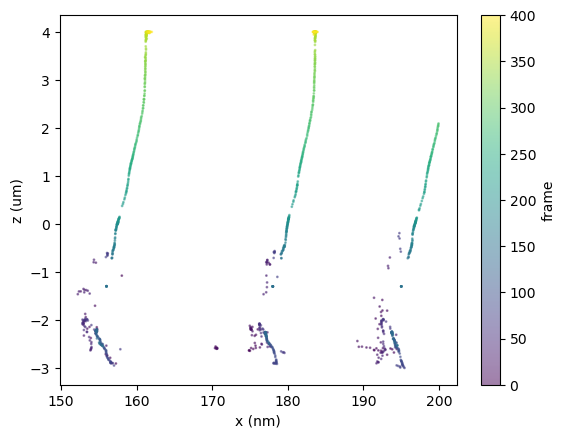

In [58]:
plt.scatter(locs_bead['x'], locs_bead['z'], c=locs_bead['frame'], s=1, alpha=0.5)
plt.colorbar(label='frame')
plt.xlabel('x (nm)')
plt.ylabel('z (um)')

Text(0, 0.5, 'z_pos (nm)')

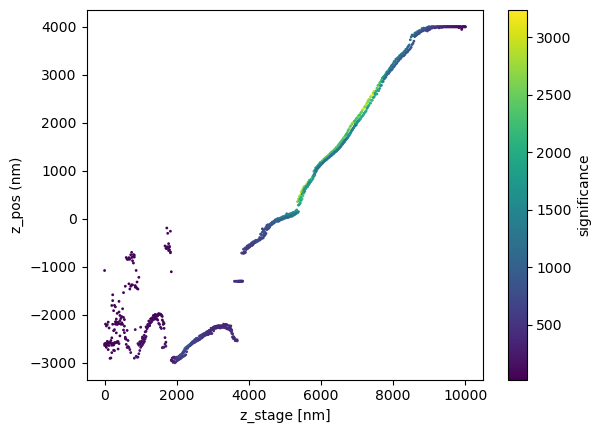

In [61]:
#locs_filter = locs[(locs['significance'] > 25) & (locs['height'] < 10000)]
locs_filter = locs_bead
z=locs_filter['z']* 1000 # convert to nm
color_var = 'significance'
plt.scatter(locs_filter['frame']*mcal['dz_stage'], z, s=1, c=locs_filter[color_var], cmap='viridis')
colorbar = plt.colorbar(label=color_var)
plt.xlabel('z_stage [nm]')
plt.ylabel('z_pos (nm)')
#locs_filter.plot.scatter(x='frame', y='z', c='significance', s=1, cmap='viridis')